In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)
 
import pickle
import jax.numpy as jnp
from src.featlin import Featlin
from src.featlin import jax_moment
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

# Whetehr to generate data or load it from file
# Load it from file to reproduce results from the paper
# Otherwise, random noise will be different, leading to different results
generate_data = 0

# Setting this variable to 1 will save the generated data to file
# And overwrite the data in the folder 
save_generated_data = 0

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

In [5]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

In [6]:
def sinus_transformation(X: np.ndarray, a=0.07) -> np.ndarray:
    Y = jnp.sin((2*jnp.pi/a) * X)
    if len(Y.shape) == 1:
        y = jnp.sum(Y)
    else:
        y = jnp.sum(Y, axis=1)
    return y

In [7]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda x : jnp.mean(x),
    lambda x: sinus_transformation(x, a=0.06), 
    lambda x : jnp.sum(x**2),
    lambda x : jnp.var(x),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]

fun_target_names = [
    'Sum',
    'Sinusoidal',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
    
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

In [8]:
# Generate BasicsData class objects
# Different examples, only the following are used in this notebook 
# 'Sum' : Simple illustration with PLS
# 'Sinus': Using RR 
# 'Sum of Squares': Using RR and std 
# 'Variance': Using RR and std
# --> 6 Case studies

if generate_data:
    # Generate BasicsData class objects
    lfp_sin = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_sin = lfp_sin.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=40)
    # y = sinusoidal_transformation(x)
    # plt.plot(x, y)

    lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_sums = lfp_sums.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=40)

    # Mean
    lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    # Sinus
    lfp_sin = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_sin = lfp_sin.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    # Sum Squares
    lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_sums = lfp_sums.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    # Variance
    lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_var = lfp_var.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    # Skew
    lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    # Kurt
    lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
    lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[5]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

    if save_generated_data:
        # Pickle data
        with open('data/lfp_sin.pkl', 'wb') as f:
            pickle.dump(lfp_sin, f)
        with open('data/lfp_sums.pkl', 'wb') as f:
            pickle.dump(lfp_sums, f)
        with open('data/lfp_mean.pkl', 'wb') as f:
            pickle.dump(lfp_mean, f)
        with open('data/lfp_var.pkl', 'wb') as f:
            pickle.dump(lfp_var, f)
        with open('data/lfp_skew.pkl', 'wb') as f:
            pickle.dump(lfp_skew, f)
        with open('data/lfp_kurt.pkl', 'wb') as f:
            pickle.dump(lfp_kurt, f)

else:
    # Load data from pickle
    with open('data/lfp_sin.pkl', 'rb') as f:
        lfp_sin = pickle.load(f)
    with open('data/lfp_sums.pkl', 'rb') as f:
        lfp_sums = pickle.load(f)
    with open('data/lfp_mean.pkl', 'rb') as f:
        lfp_mean = pickle.load(f)
    with open('data/lfp_var.pkl', 'rb') as f:
        lfp_var = pickle.load(f)
    with open('data/lfp_skew.pkl', 'rb') as f:
        lfp_skew = pickle.load(f)
    with open('data/lfp_kurt.pkl', 'rb') as f:
        lfp_kurt = pickle.load(f)


# Log Cycle Life, no ramdon noise added, because the measured data has already noise
lfp_lcl = BasicsData(X=X_lfp_train, x=x_lfp, y=np.log(y_lfp_train_true))

Constraint value: 0.109664495328, Method Xv
Constraint value: 0.199999909990, Method Xv
Constraint value: 0.200000097338, Method Xv
Constraint value: 0.200000282500, Method Xv
Constraint value: 0.200000749302, Method Xv
Constraint value: 0.200000917185, Method Xv


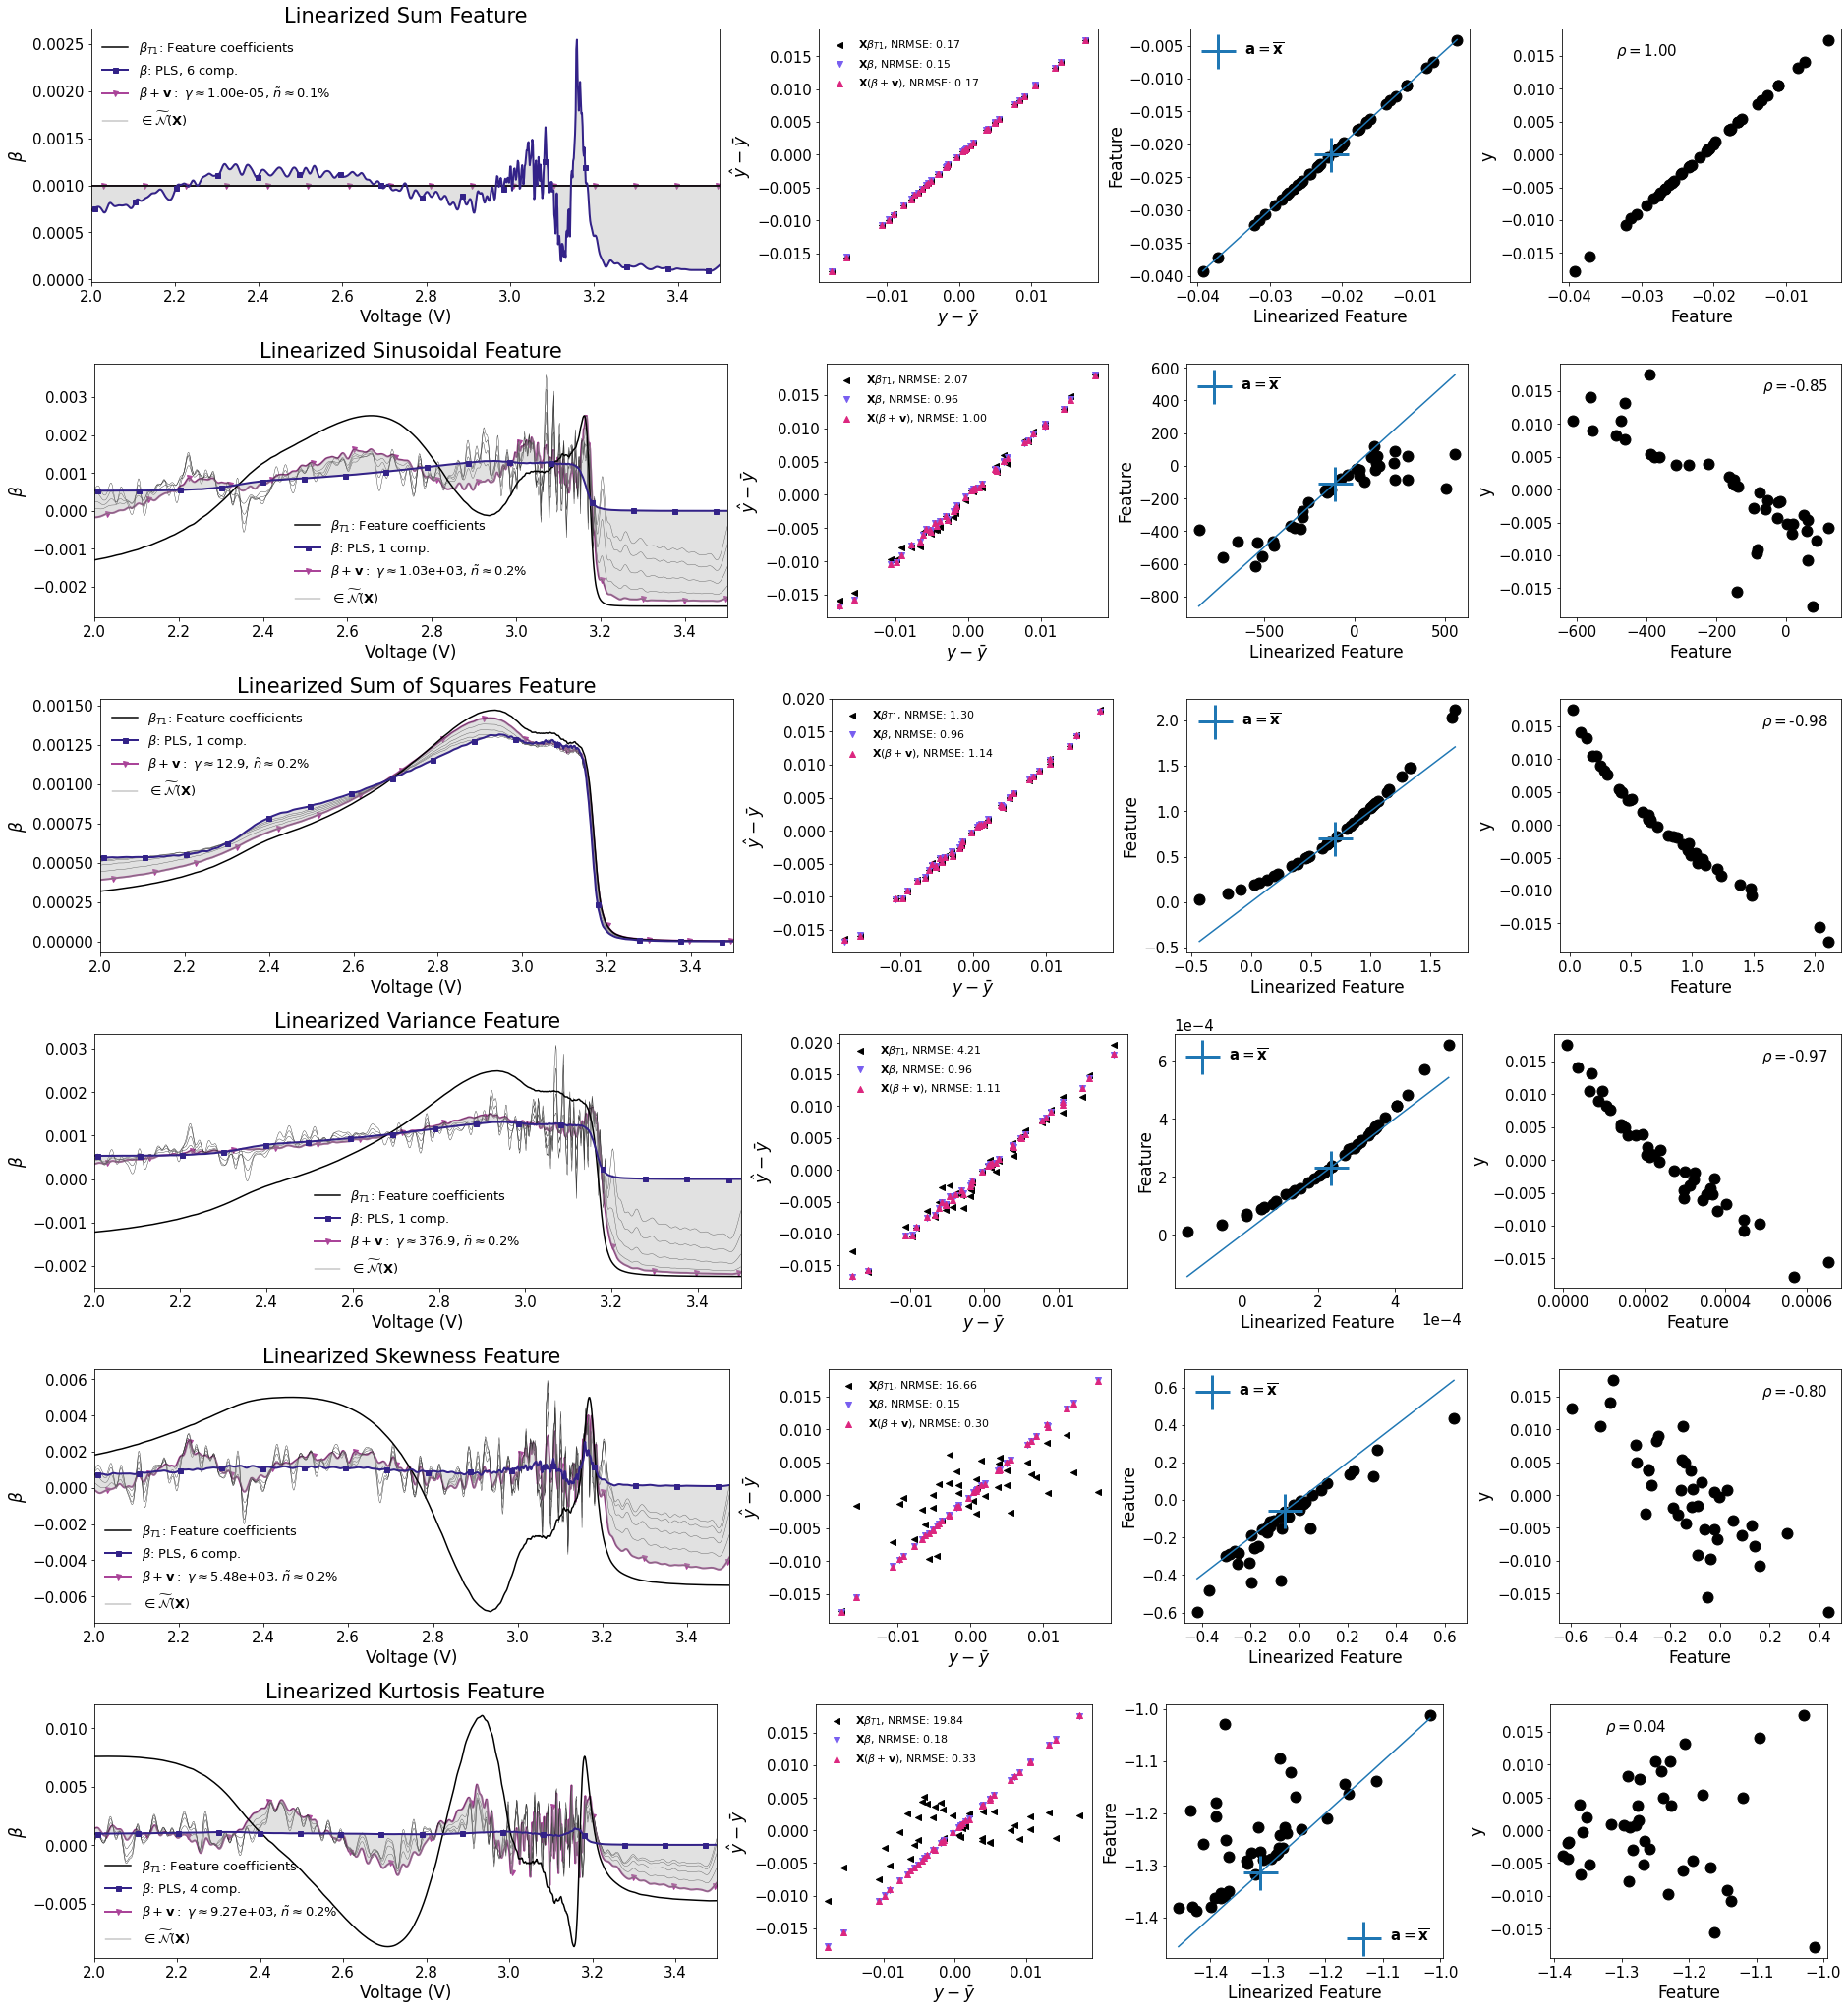

In [9]:
# 'Sum' : Simple illustration with PLS
# Simple illustration inc ase model and ground truth are linear
lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'mean_gt_PLS_',
             'multiple_fig':False}

# TODO: , gray_line_params=None, implementation to obtain desired plots.
lfp_meangt = lfp_meangt.analyze_all_features(
    opt_cv={'active':False, 'model': []}, 
    opt_dist={'active':True, 'model': ['PLS']},
    fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.2, verbose=False)

# 0.109664495328 # 0.17 # 0.15 # 0,17
# 0.199999909990 # 2.07 # 0.96 # 1.00
# 0.200000097338

Constraint value: 0.499999534979, Method Xv
Constraint value: 0.500000076571, Method Xv
Constraint value: 0.499998617142, Method Xv
Constraint value: 0.500000975438, Method Xv
Constraint value: 0.499998129173, Method Xv
Constraint value: 0.499999697404, Method Xv


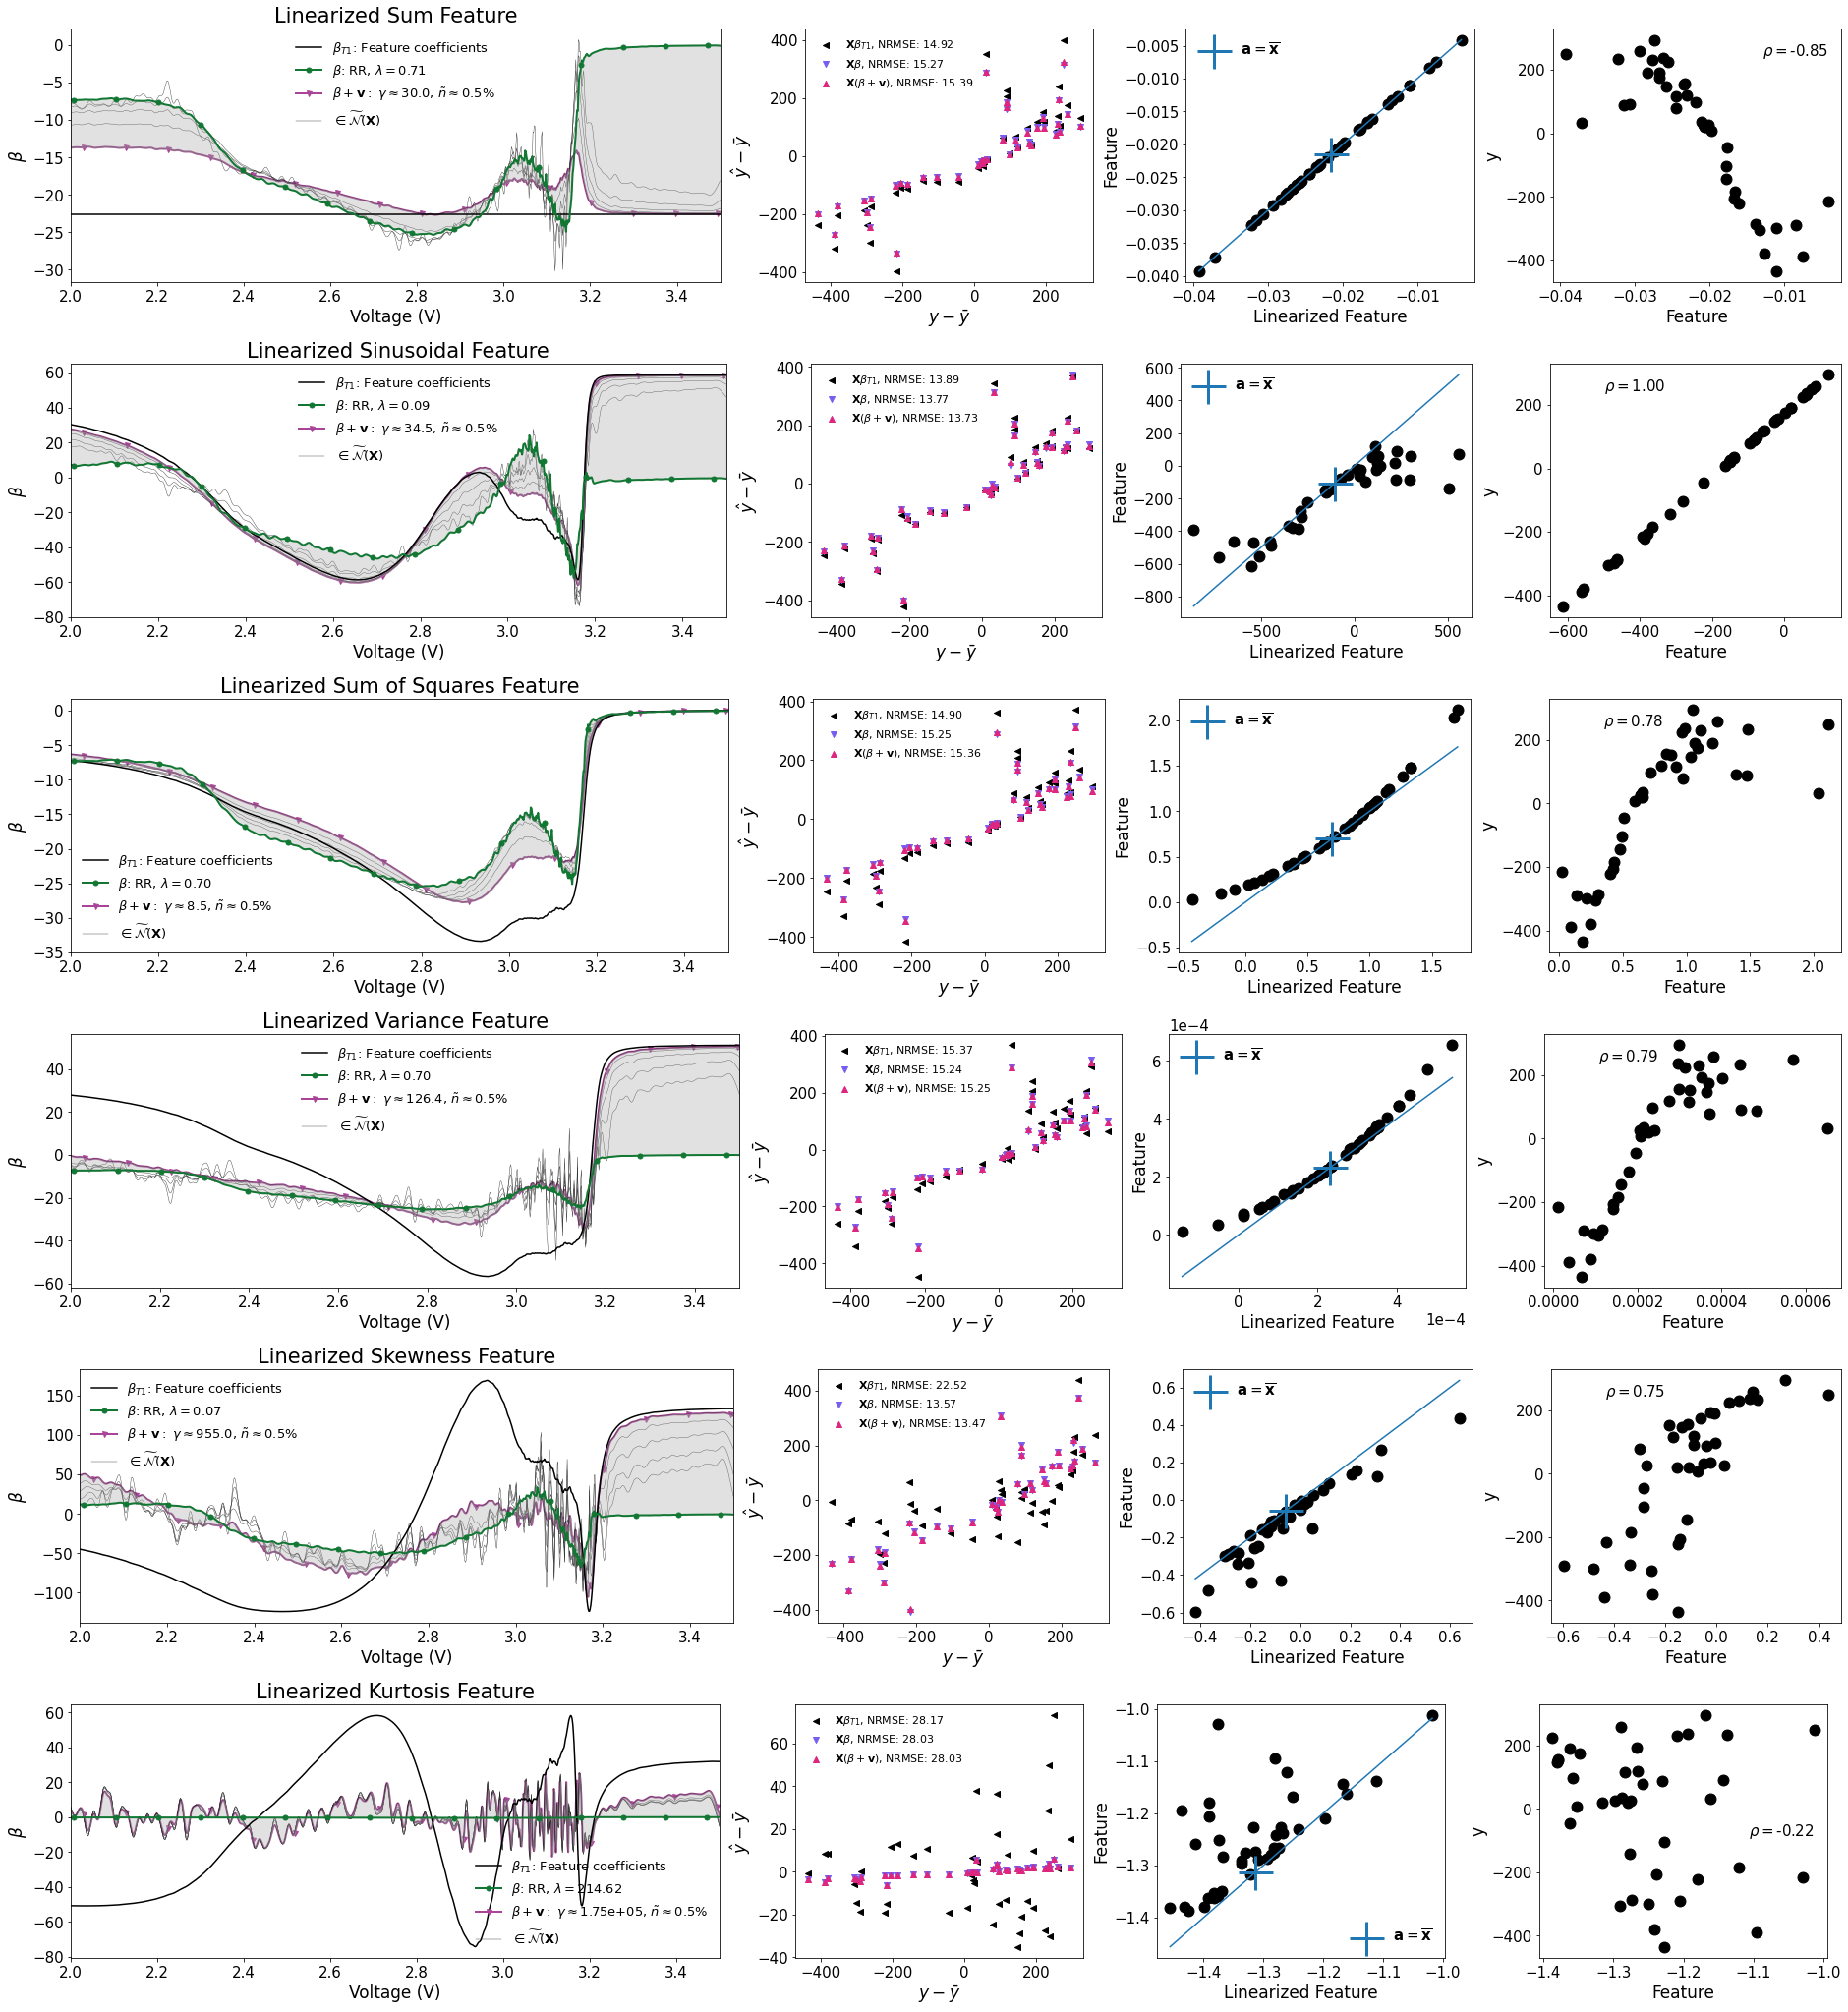

In [10]:
# 'Sinus': Using RR 
lfp_singt = Featlin(data_obj=lfp_sin, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'sin_gt_RR_',
             'multiple_fig':False}

lfp_singt = lfp_singt.analyze_all_features(
    opt_cv={'active':False, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']},
    fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)


Constraint value: 0.500001073047, Method Xv
Constraint value: 0.500000250798, Method Xv
Constraint value: 0.500001223934, Method Xv
Constraint value: 0.499998270709, Method Xv
Constraint value: 0.500000499230, Method Xv
Constraint value: 0.499999436341, Method Xv


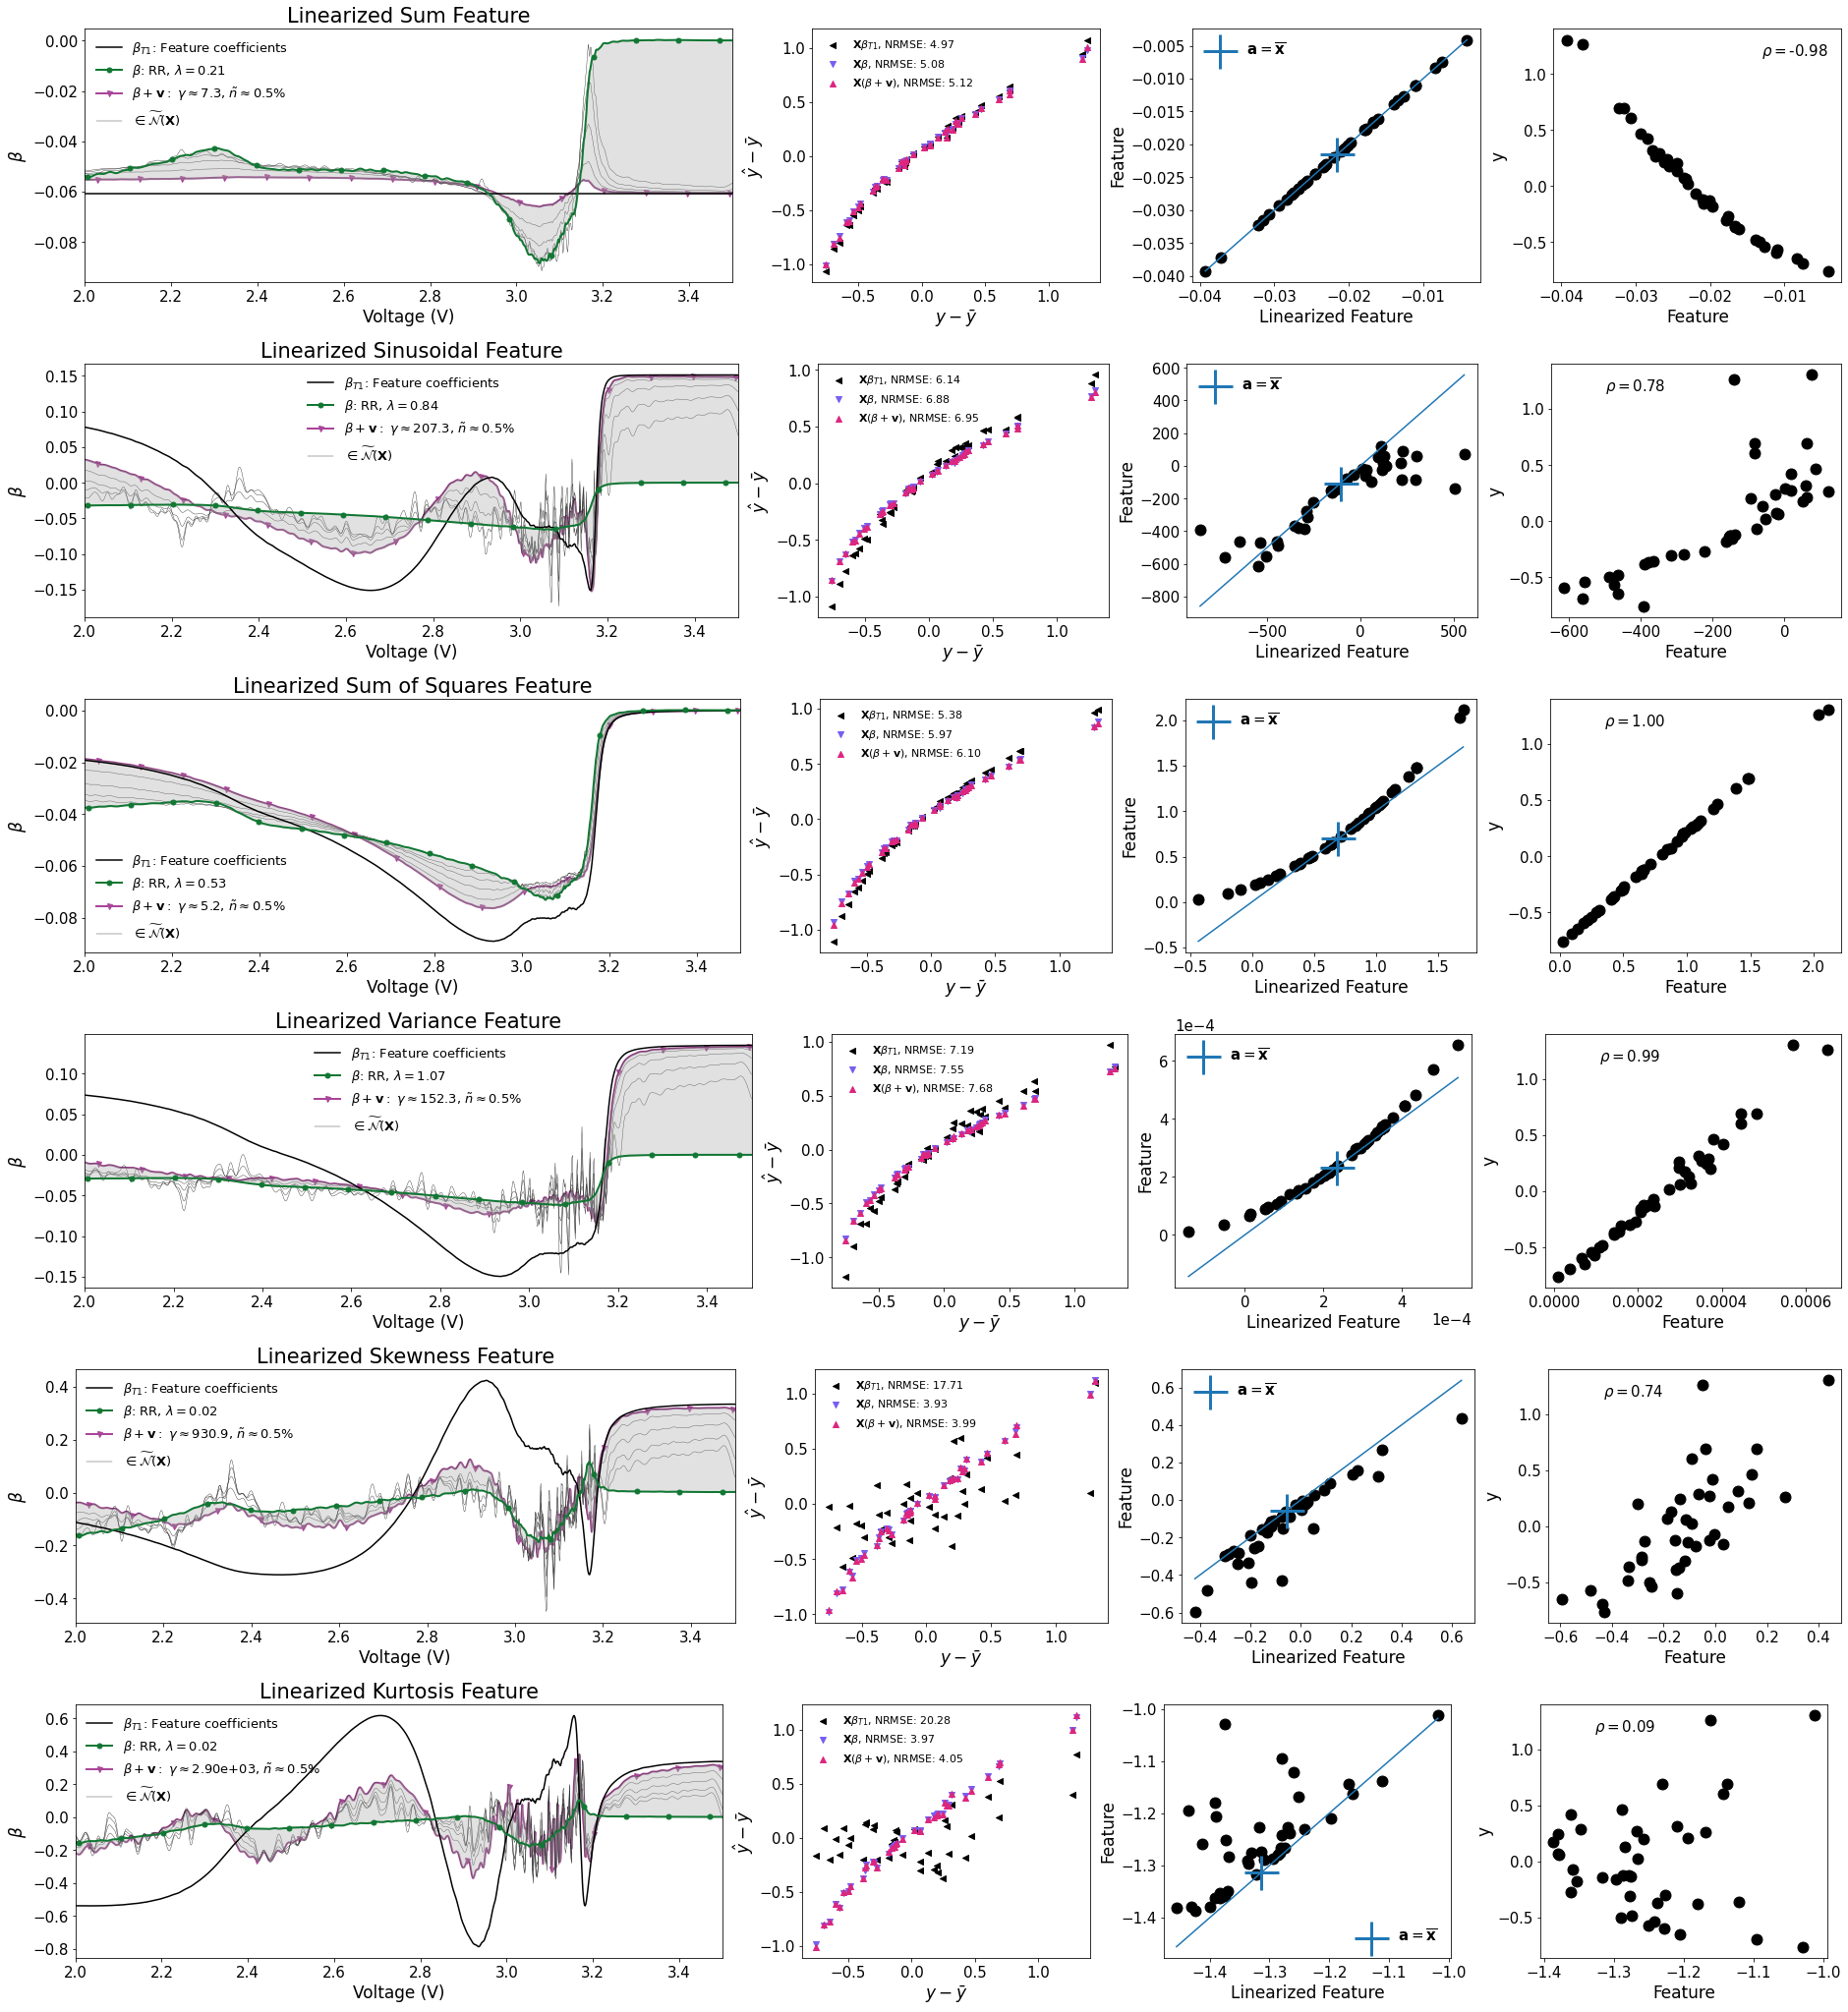

In [11]:
# 'Sum of Squares': Using RR
lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'sums_gt_RR_',
             'multiple_fig':False}

# Run the tests
lfp_sums_gt = lfp_sums_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']},
    fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
plt.show()

Constraint value: 0.500001073047, Method Xv
Constraint value: 0.500000250798, Method Xv
Constraint value: 0.500001223934, Method Xv
Constraint value: 0.499998270709, Method Xv
Constraint value: 0.500000499230, Method Xv
Constraint value: 0.499999436341, Method Xv


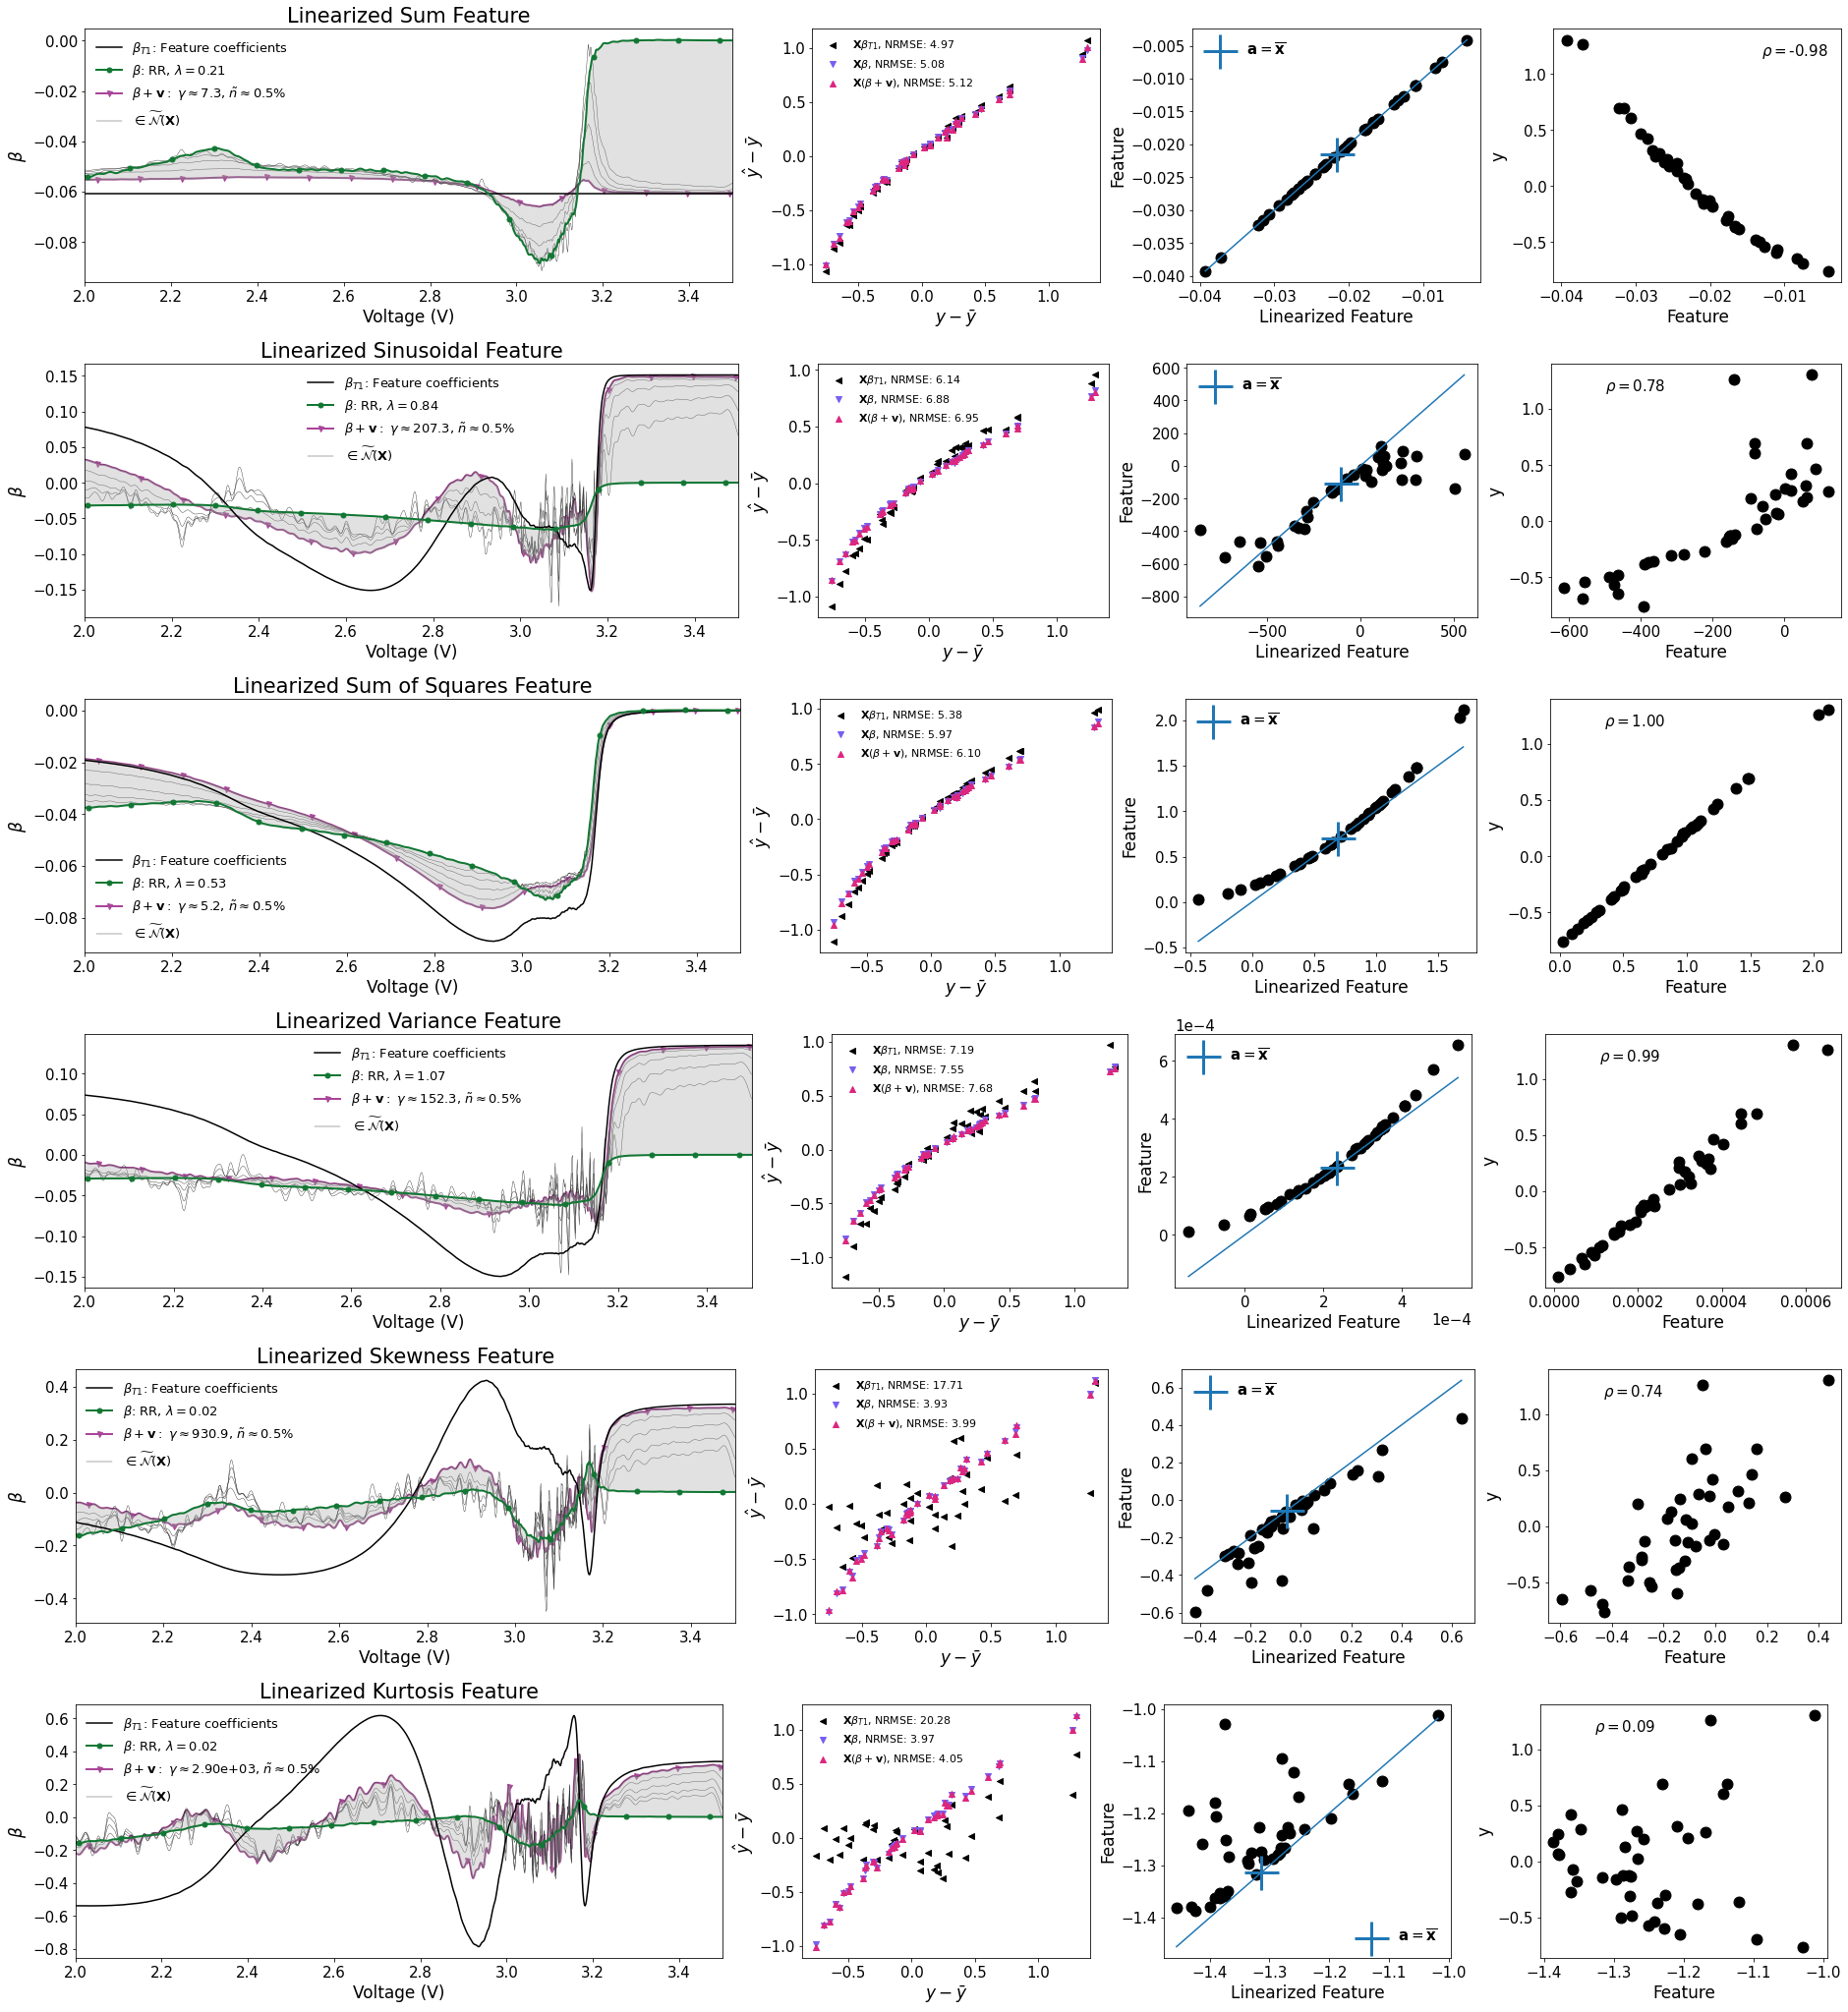

In [12]:
# 'Sum of Squares': Using RR and std 
# Feature linearization done such that it corresponds to standardized data!
# All regression coefficeints thus corresponding to standardized data --> Scale will be very different here! 


lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'sums_gt_RR_',
             'multiple_fig':False}

# Run the tests
lfp_sums_gt = lfp_sums_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']},
    fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)

Constraint value: 0.500000510093, Method Xv
Constraint value: 0.499998940978, Method Xv
Constraint value: 0.499999151314, Method Xv
Constraint value: 0.499997690828, Method Xv
Constraint value: 0.499999972364, Method Xv
Constraint value: 0.499997482014, Method Xv


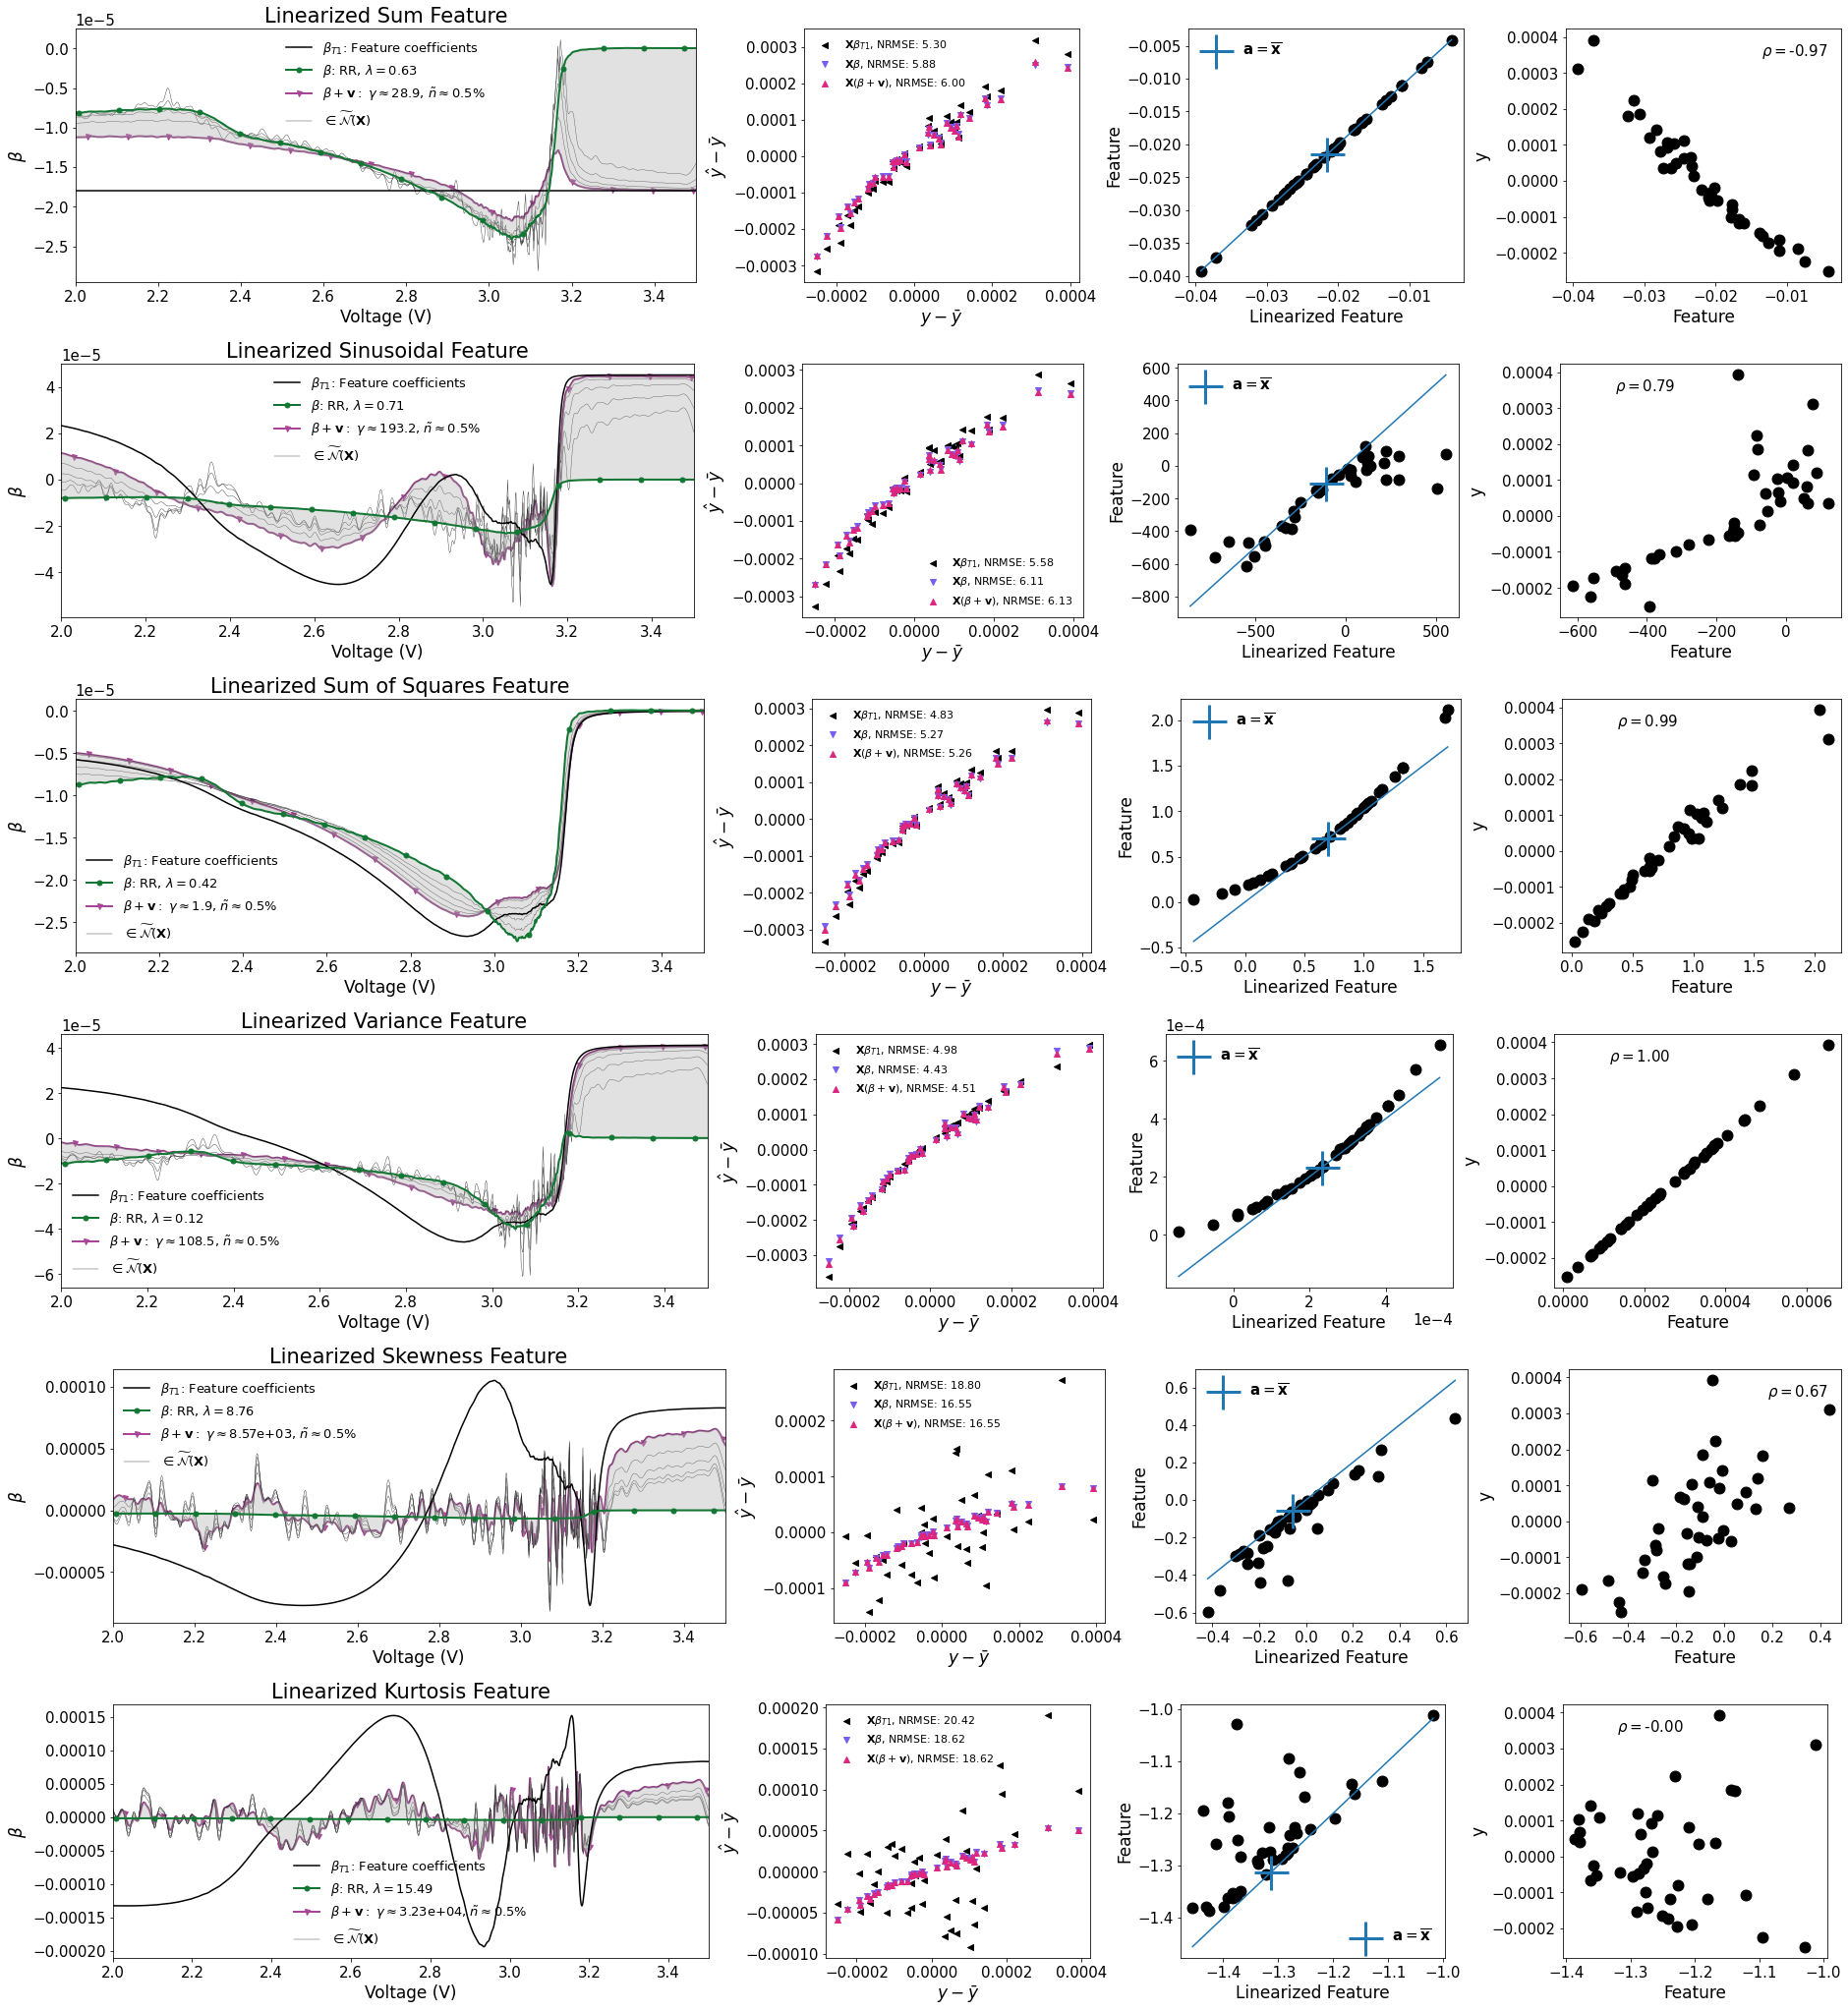

In [13]:
# 'Variance': Using RR
lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'variance_gt_RR_',
            'multiple_fig':False}

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
plt.show()

Constraint value: 0.500001698430, Method Xv
Constraint value: 0.500000930573, Method Xv
Constraint value: 0.304836262982, Method Xv
Constraint value: 0.500002267908, Method Xv
Constraint value: 0.499999046832, Method Xv
Constraint value: 0.500001388658, Method Xv


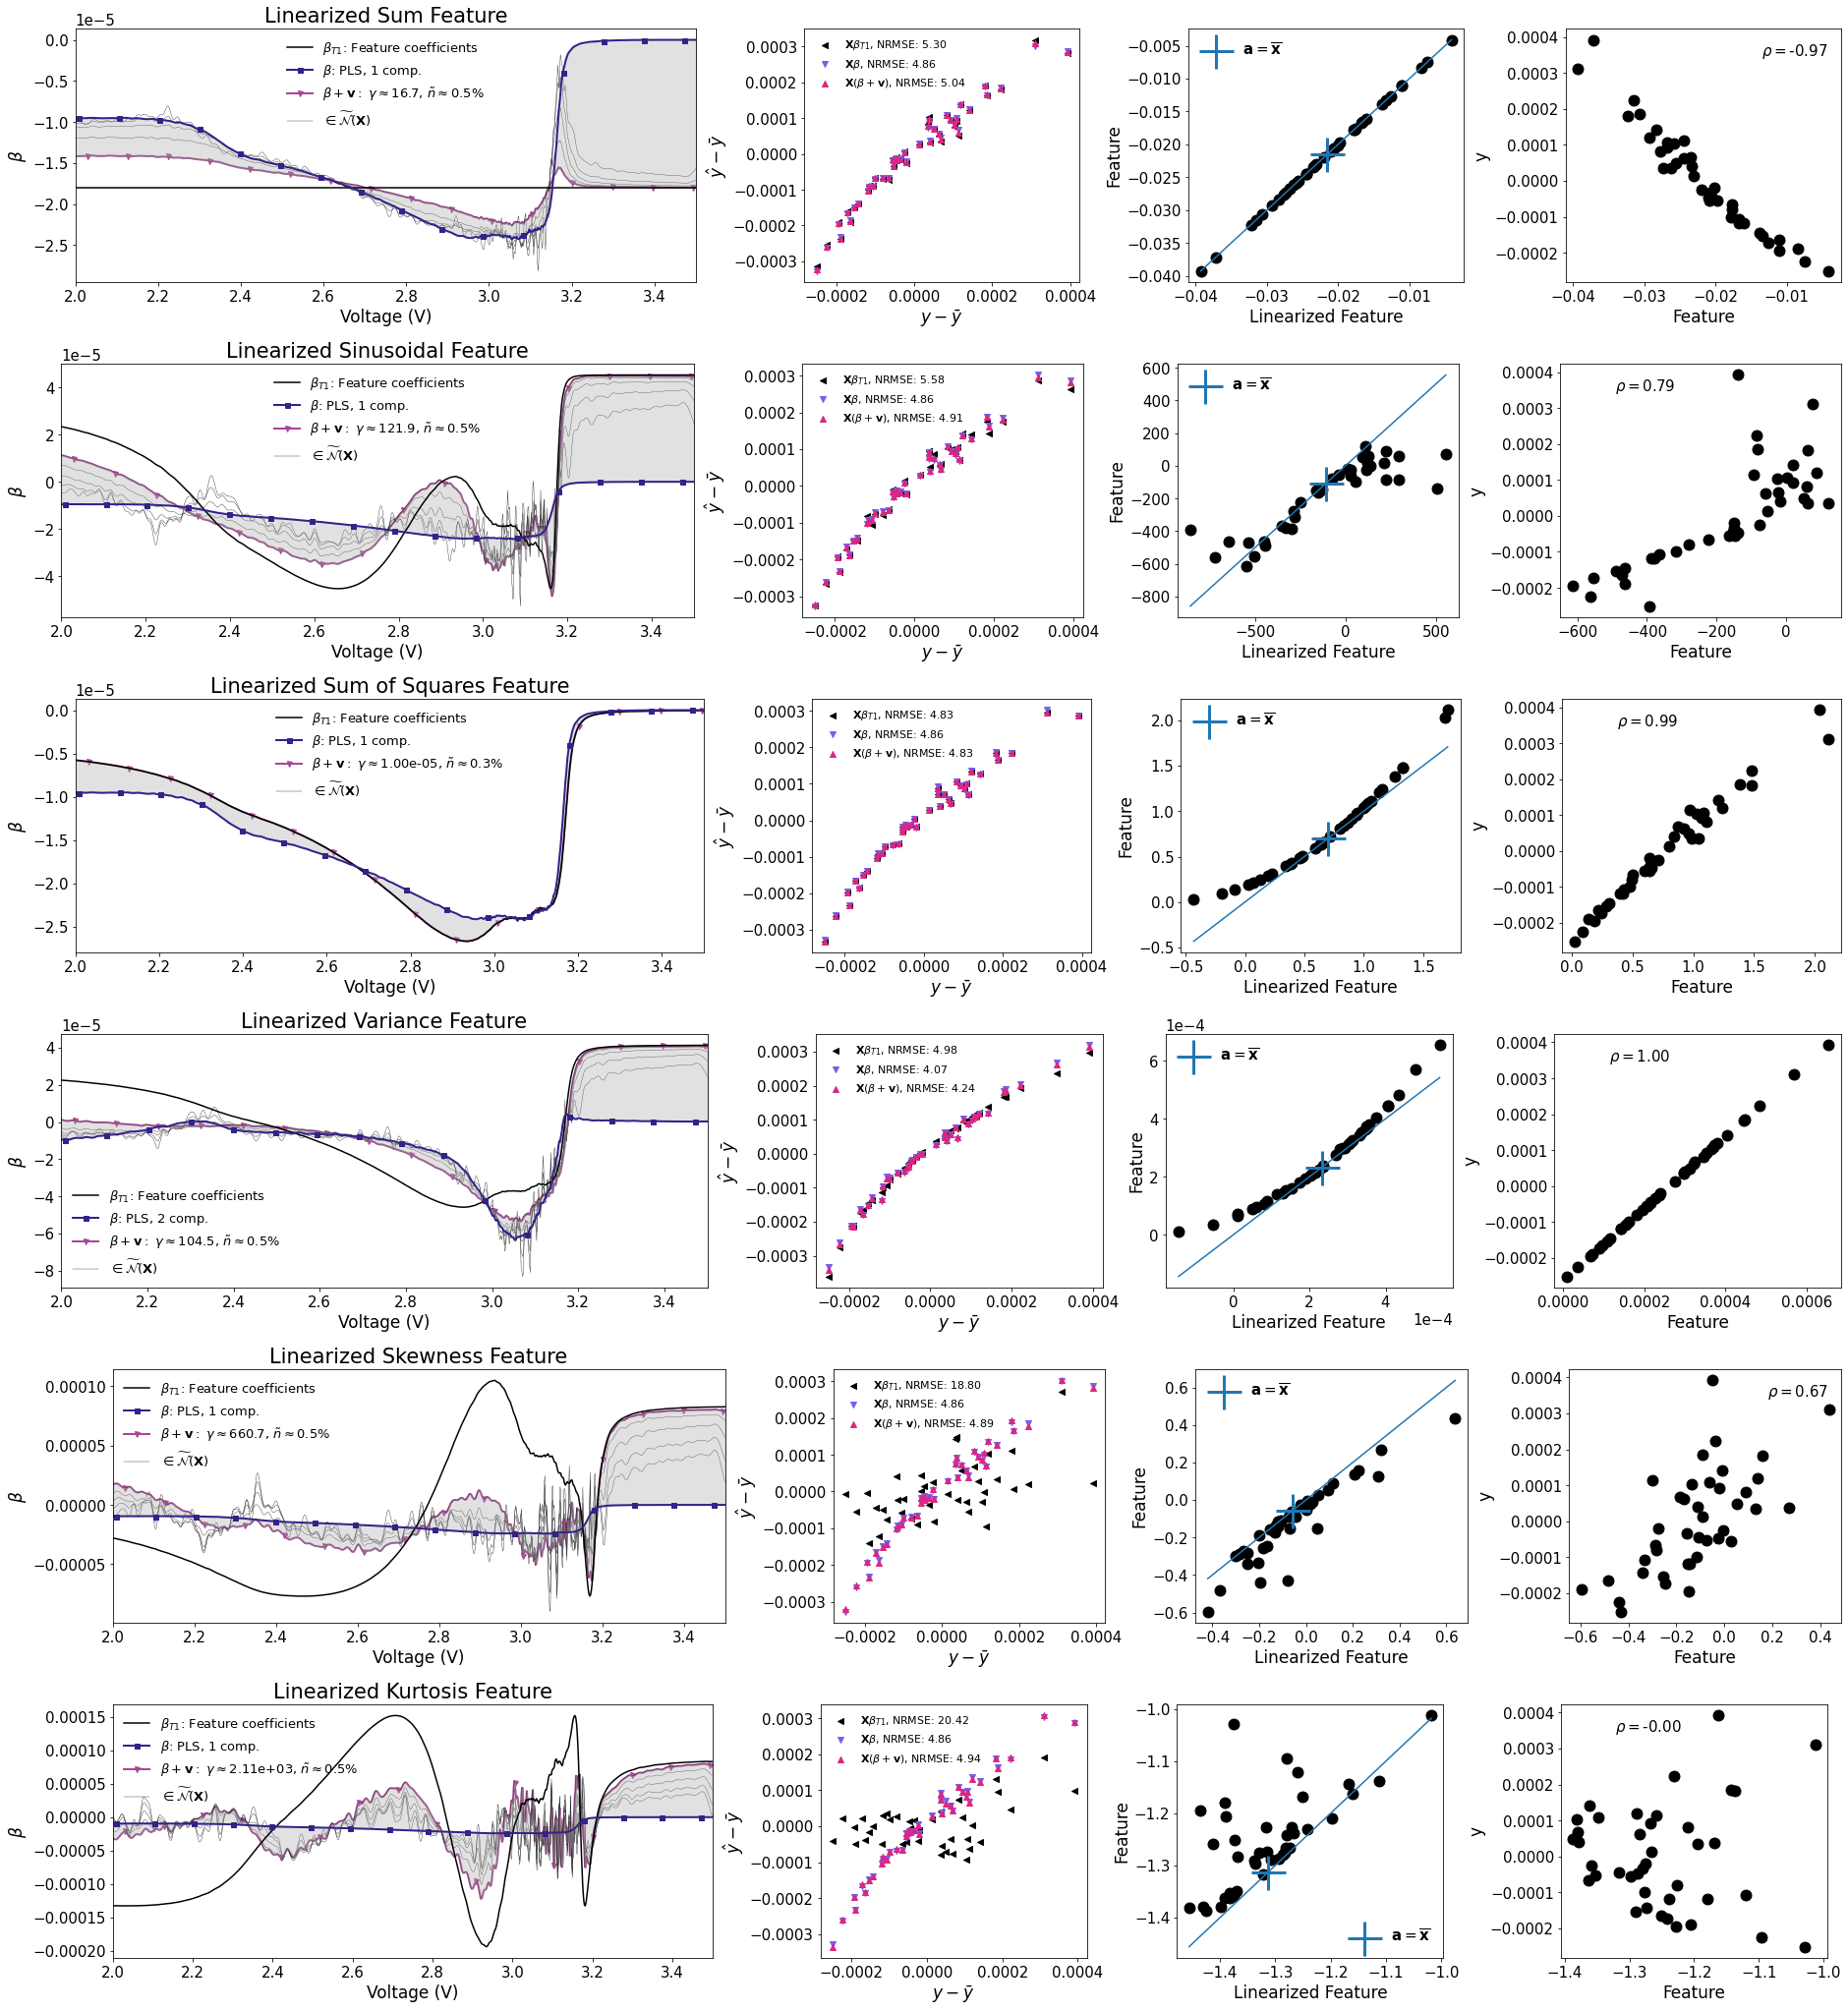

In [14]:
# 'Variance': Using PLS
fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'variance_gt_PLS', 
             'multiple_fig':False, 'response':'Groundtruth Response: Variance'}

lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['PLS']}, 
    fig_props = fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)

Constraint value: 0.500000510093, Method Xv
Constraint value: 0.499998940978, Method Xv
Constraint value: 0.499999151314, Method Xv
Constraint value: 0.499997690828, Method Xv
Constraint value: 0.499999972364, Method Xv
Constraint value: 0.499997482014, Method Xv


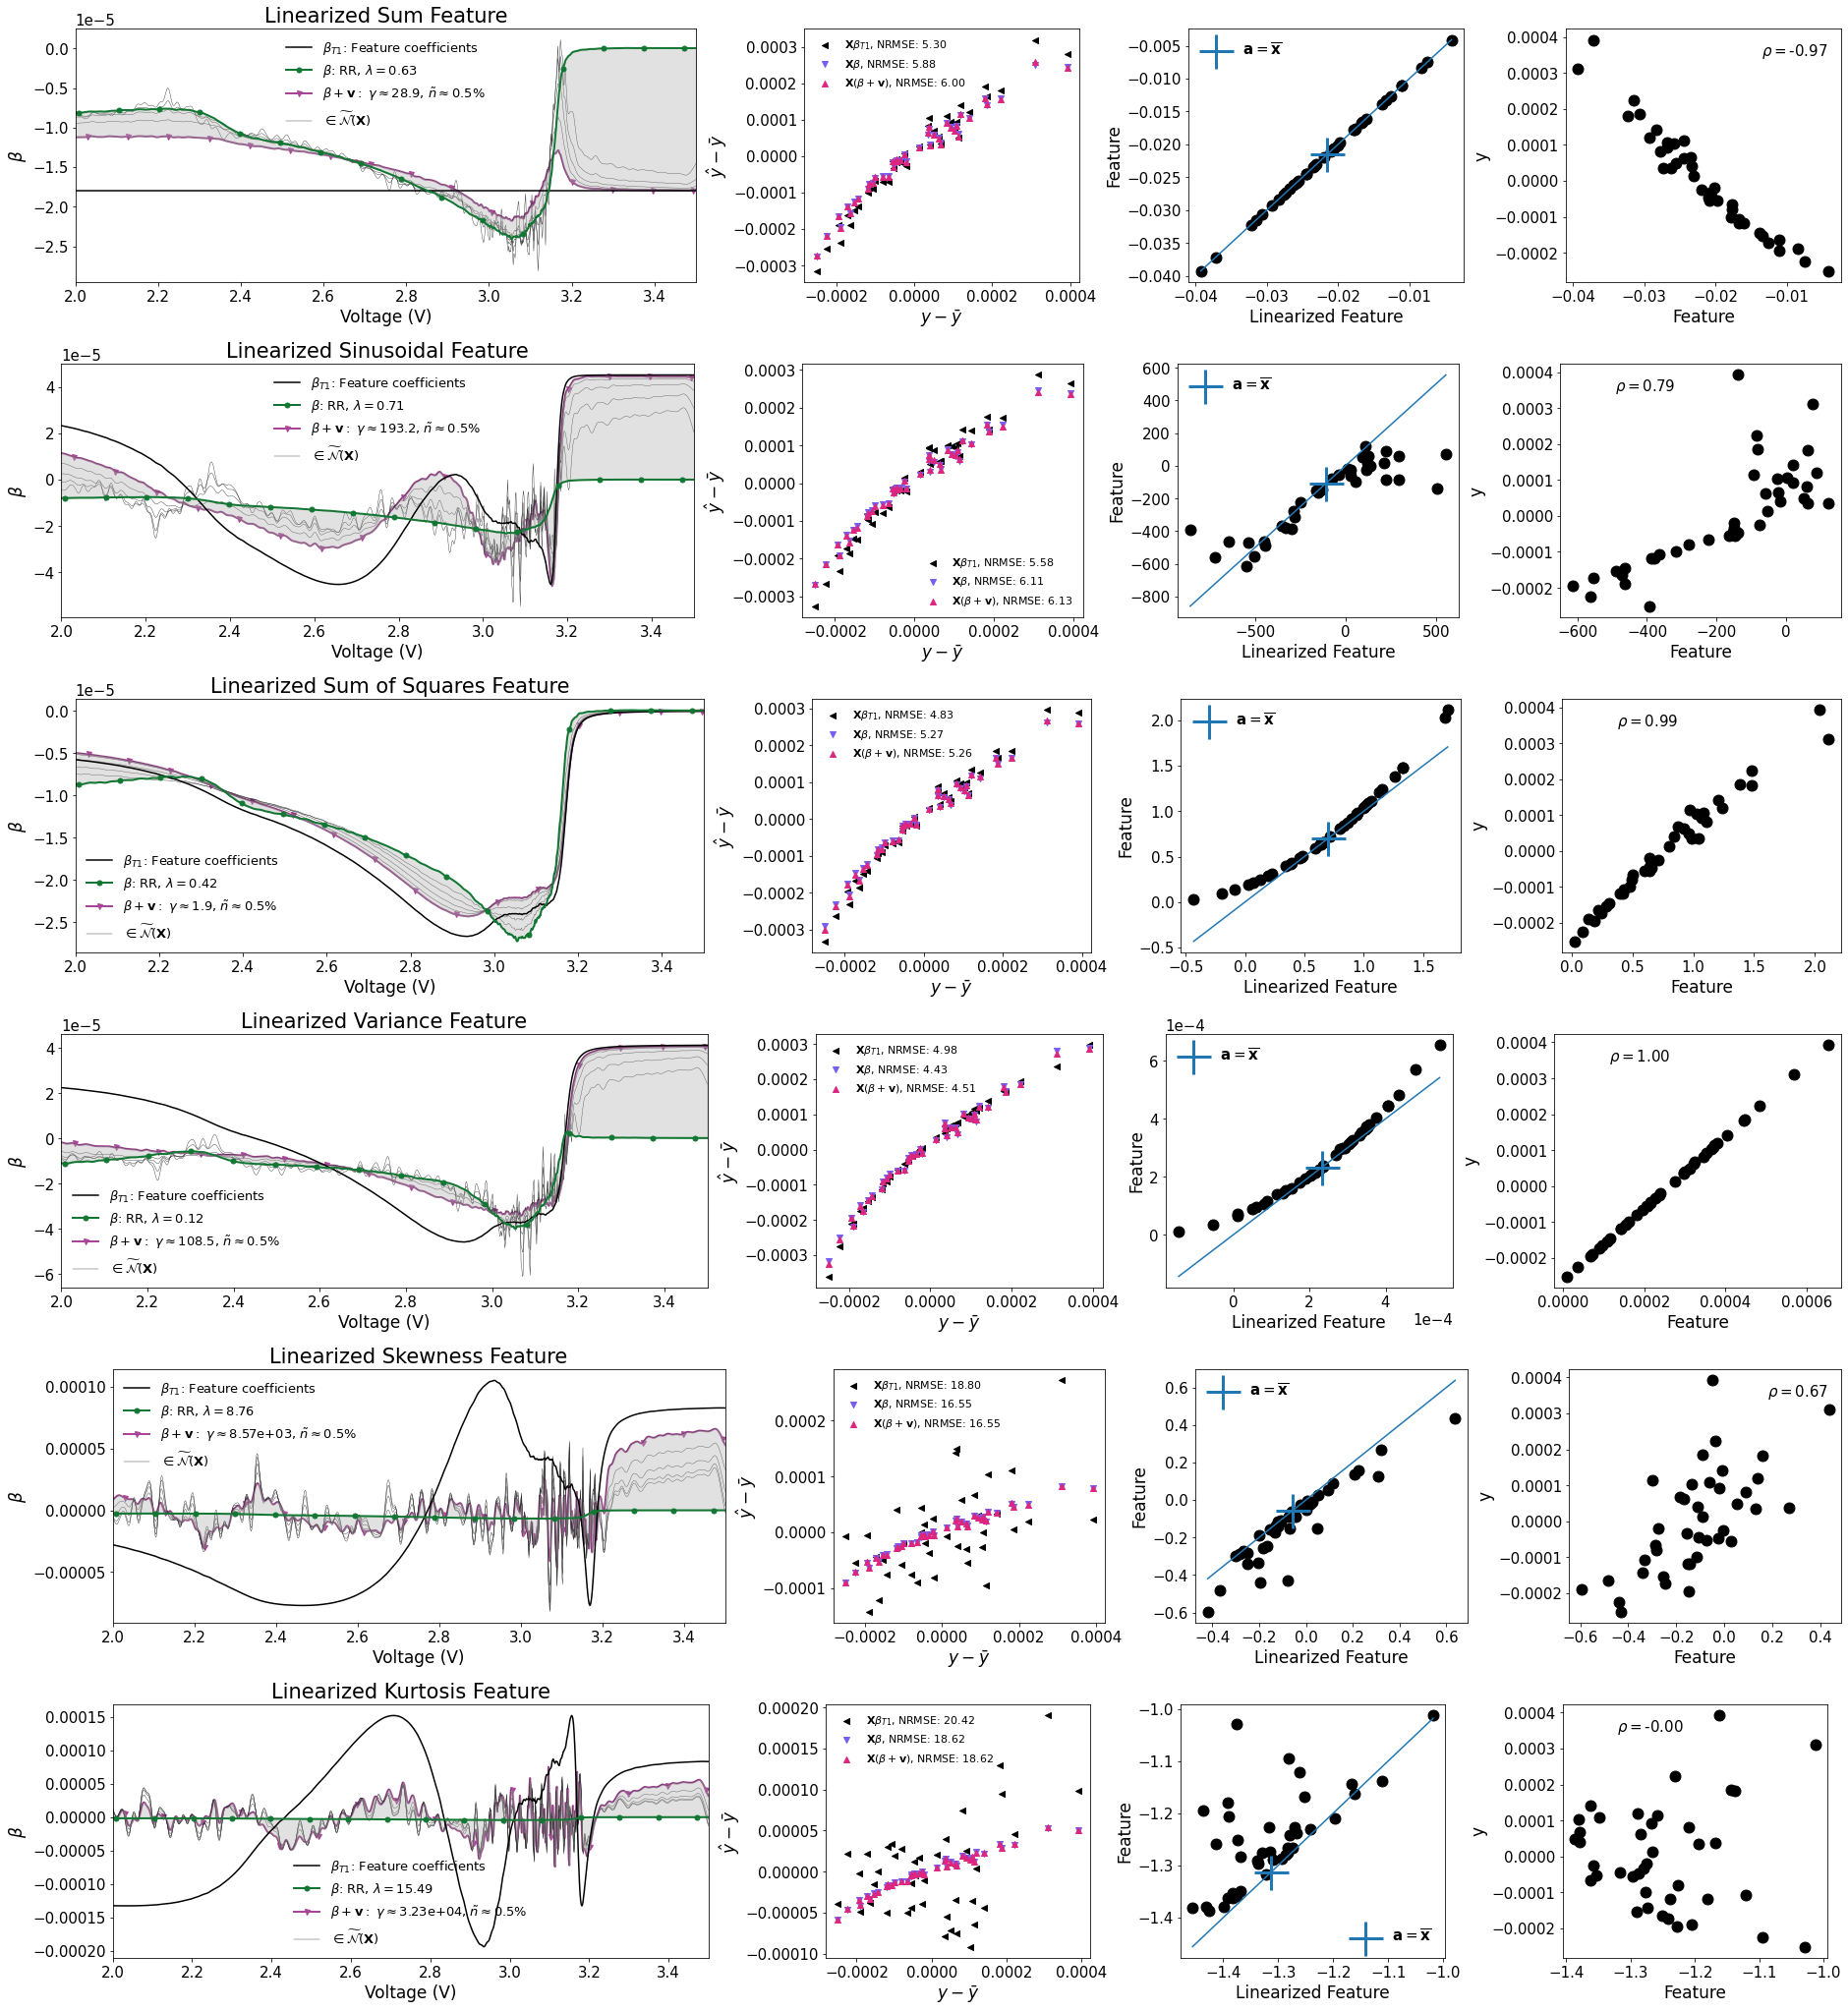

In [15]:
# 'Variance': Using RR and std
# PLot of the linearized one is not right. Fix thast bug.
lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'variance_gt_RR_std',
            'multiple_fig':False}

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)

Constraint value: 0.499998904206, Method Xv
Constraint value: 0.500000685453, Method Xv
Constraint value: 0.499999752662, Method Xv
Constraint value: 0.500002496552, Method Xv
Constraint value: 0.499998675850, Method Xv
Constraint value: 0.500000045198, Method Xv


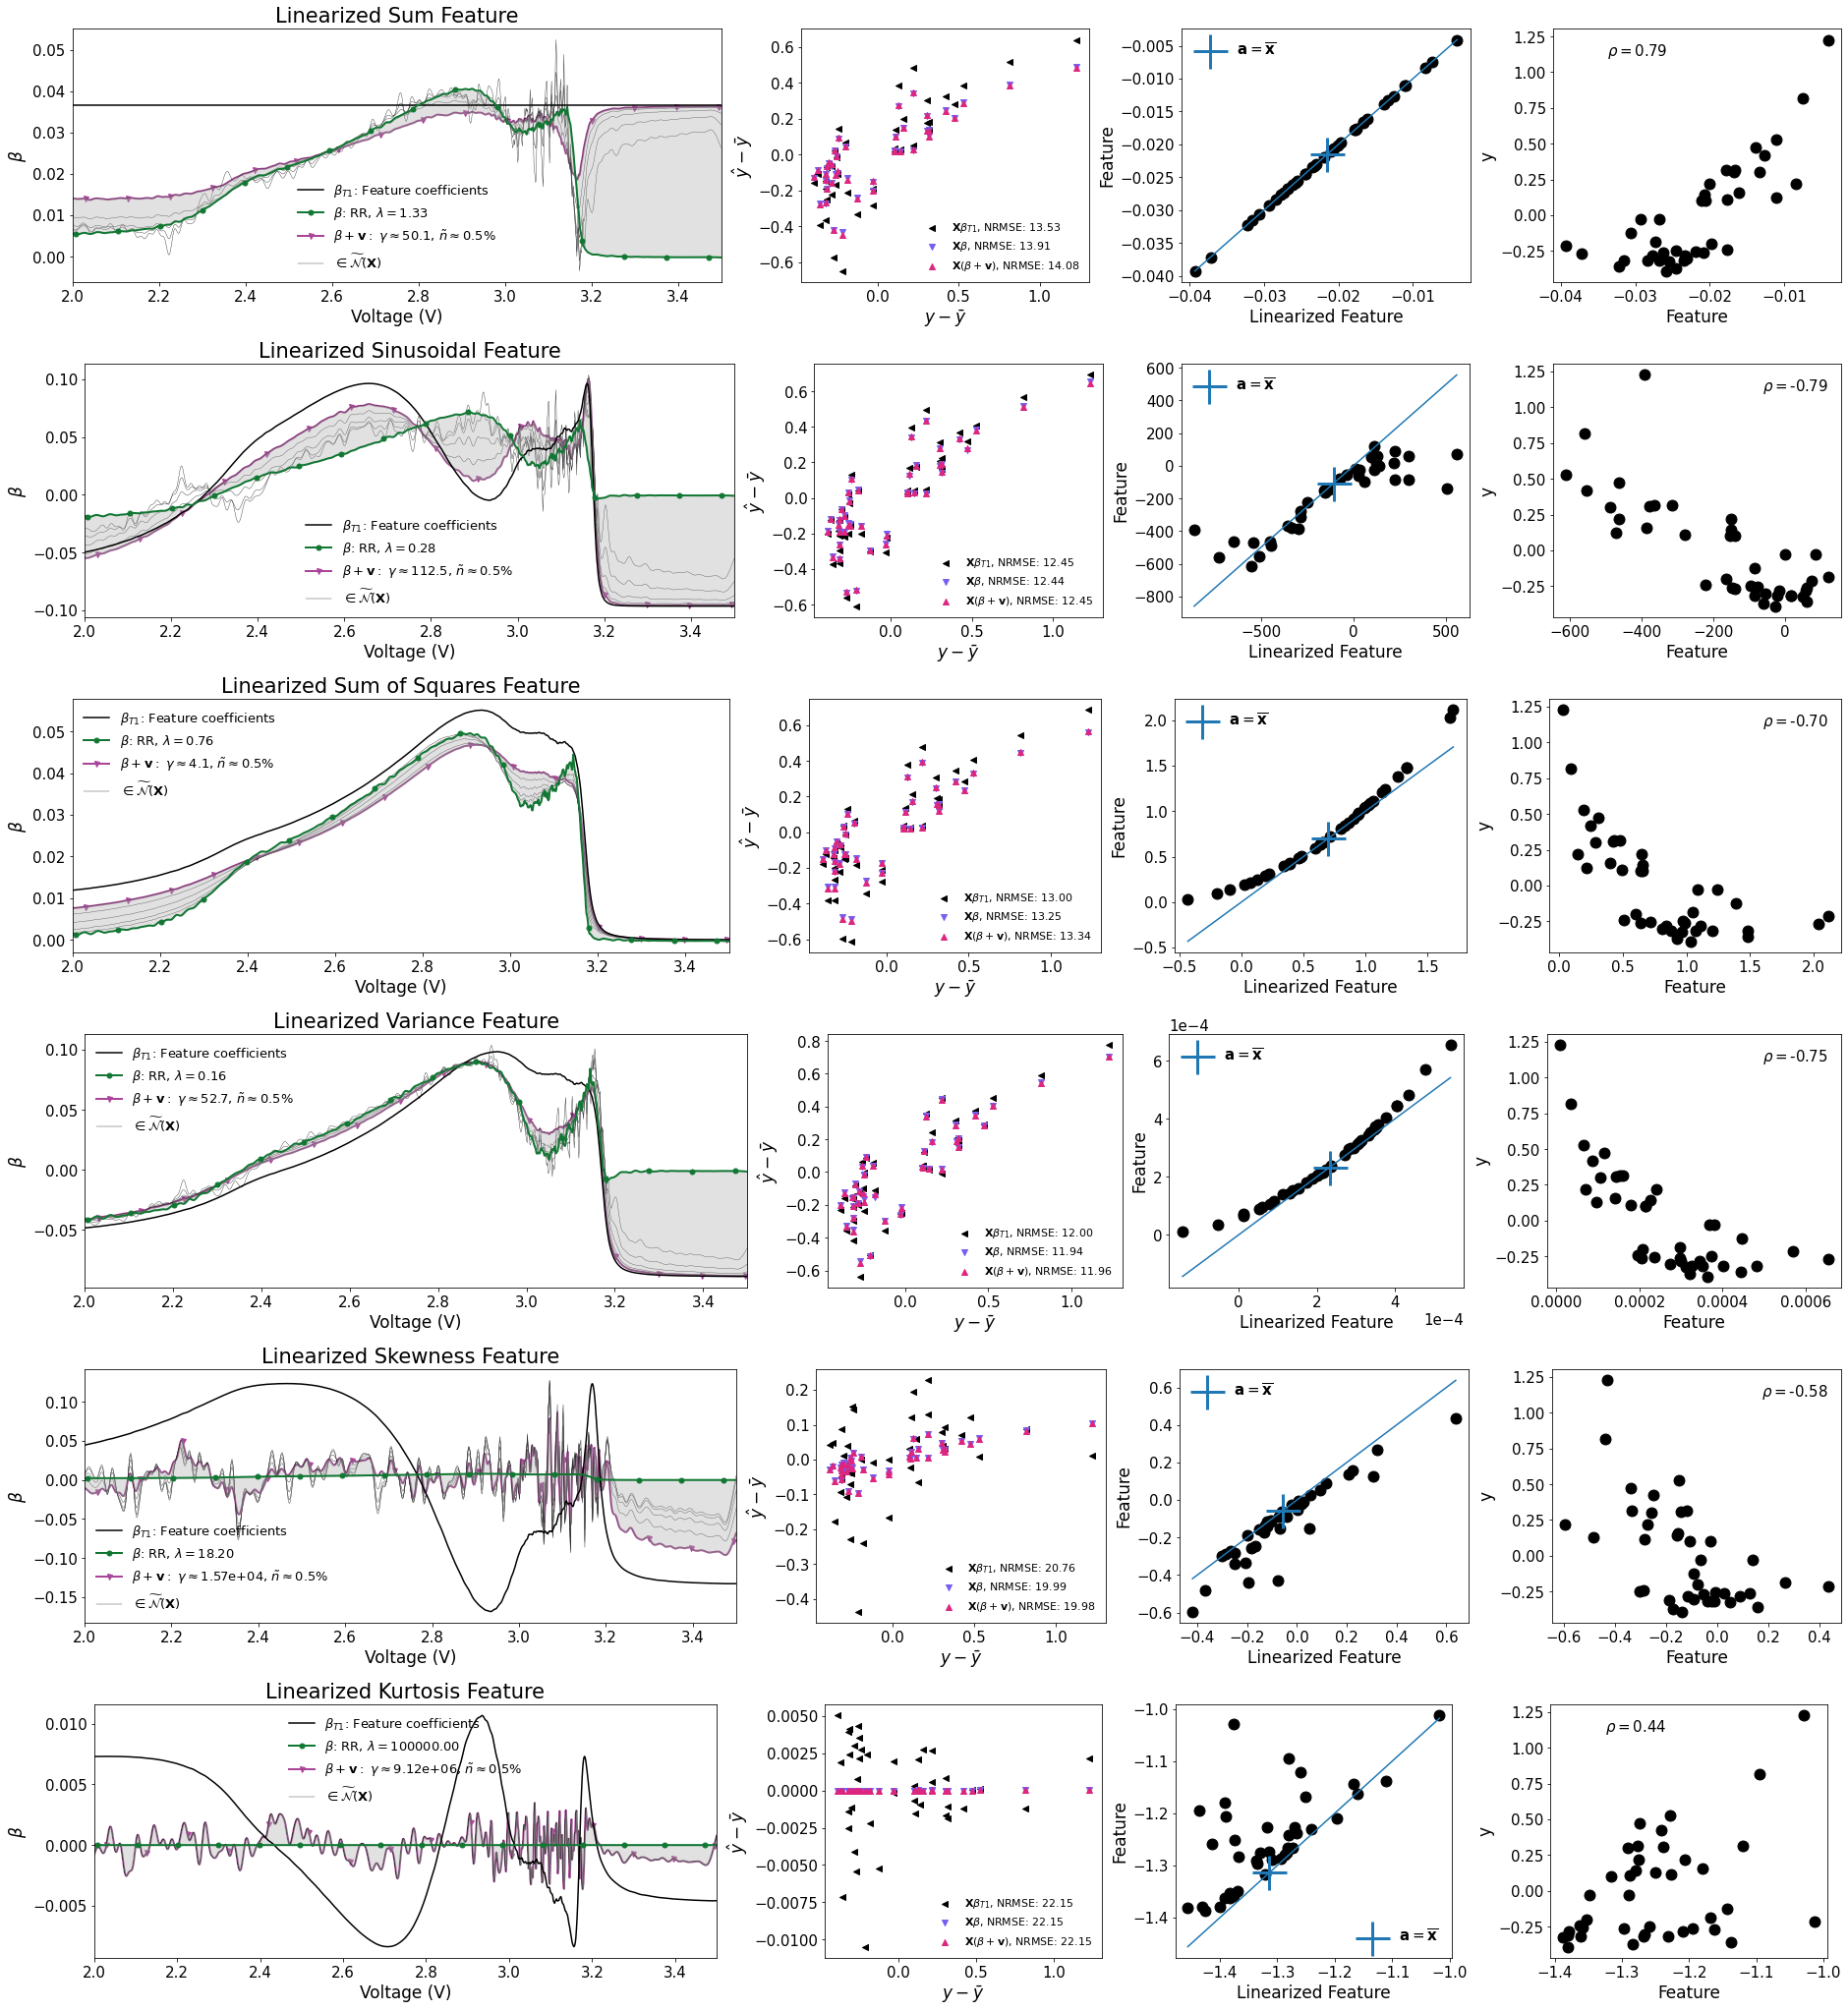

In [16]:
# Log Cycle Life
fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'LCL_RR_',
            'multiple_fig':False}

fl_lfp_lcl = Featlin(data_obj=lfp_lcl, feat_funcs=feat_fun_dict)

# Run the tests
fl_lfp_lcl = fl_lfp_lcl.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props,opt_gamma_method='Xv', con_thres=0.5, verbose=False)
plt.show()

In [17]:
more_analysis = False

In [18]:
if more_analysis: 
    fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'skew_PLS_', 'multiple_fig':False}
    # Inititate the class with data (x, y) & features that you want to test
    lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_skew_gt = lfp_skew_gt.analyze_all_features(
        opt_cv={'active':True, 'model': []}, 
        opt_dist={'active':True, 'model': ['PLS']}, 
        fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
    plt.show()

In [19]:
if more_analysis: 
    # Inititate the class with data (x, y) & features that you want to test
    fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'skew_RR_', 'multiple_fig':False}
    lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_skew_gt = lfp_skew_gt.analyze_all_features(
        opt_cv={'active':True, 'model': []}, 
        opt_dist={'active':True, 'model': ['RR']}, 
        fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
    plt.show()

In [20]:
# Kurtosis Feature is strongly nonlinear and the method is not able to capture it

In [21]:
if more_analysis: 
    # Inititate the class with data (x, y) & features that you want to test
    lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)
    fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'kurt_PLS_', 'multiple_fig':False}

    # Run the tests
    lfp_kurt_gt = lfp_kurt_gt.analyze_all_features(
        opt_cv={'active':True, 'model': []}, 
        opt_dist={'active':True, 'model': ['PLS']}, 
        fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
    plt.show()

In [22]:
if more_analysis: 
    # Inititate the class with data (x, y) & features that you want to test
    lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)
    fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'kurt_RR_', 'multiple_fig':False}
    # Run the tests
    lfp_kurt_gt = lfp_kurt_gt.analyze_all_features(
        opt_cv={'active':True, 'model': []}, 
        opt_dist={'active':True, 'model': ['RR']}, 
        fig_props=fig_props, opt_gamma_method='Xv', con_thres=0.5, verbose=False)
    plt.show()

Constraint value: 0.499998904206, Method Xv
Constraint value: 0.500000685453, Method Xv


KeyboardInterrupt: 

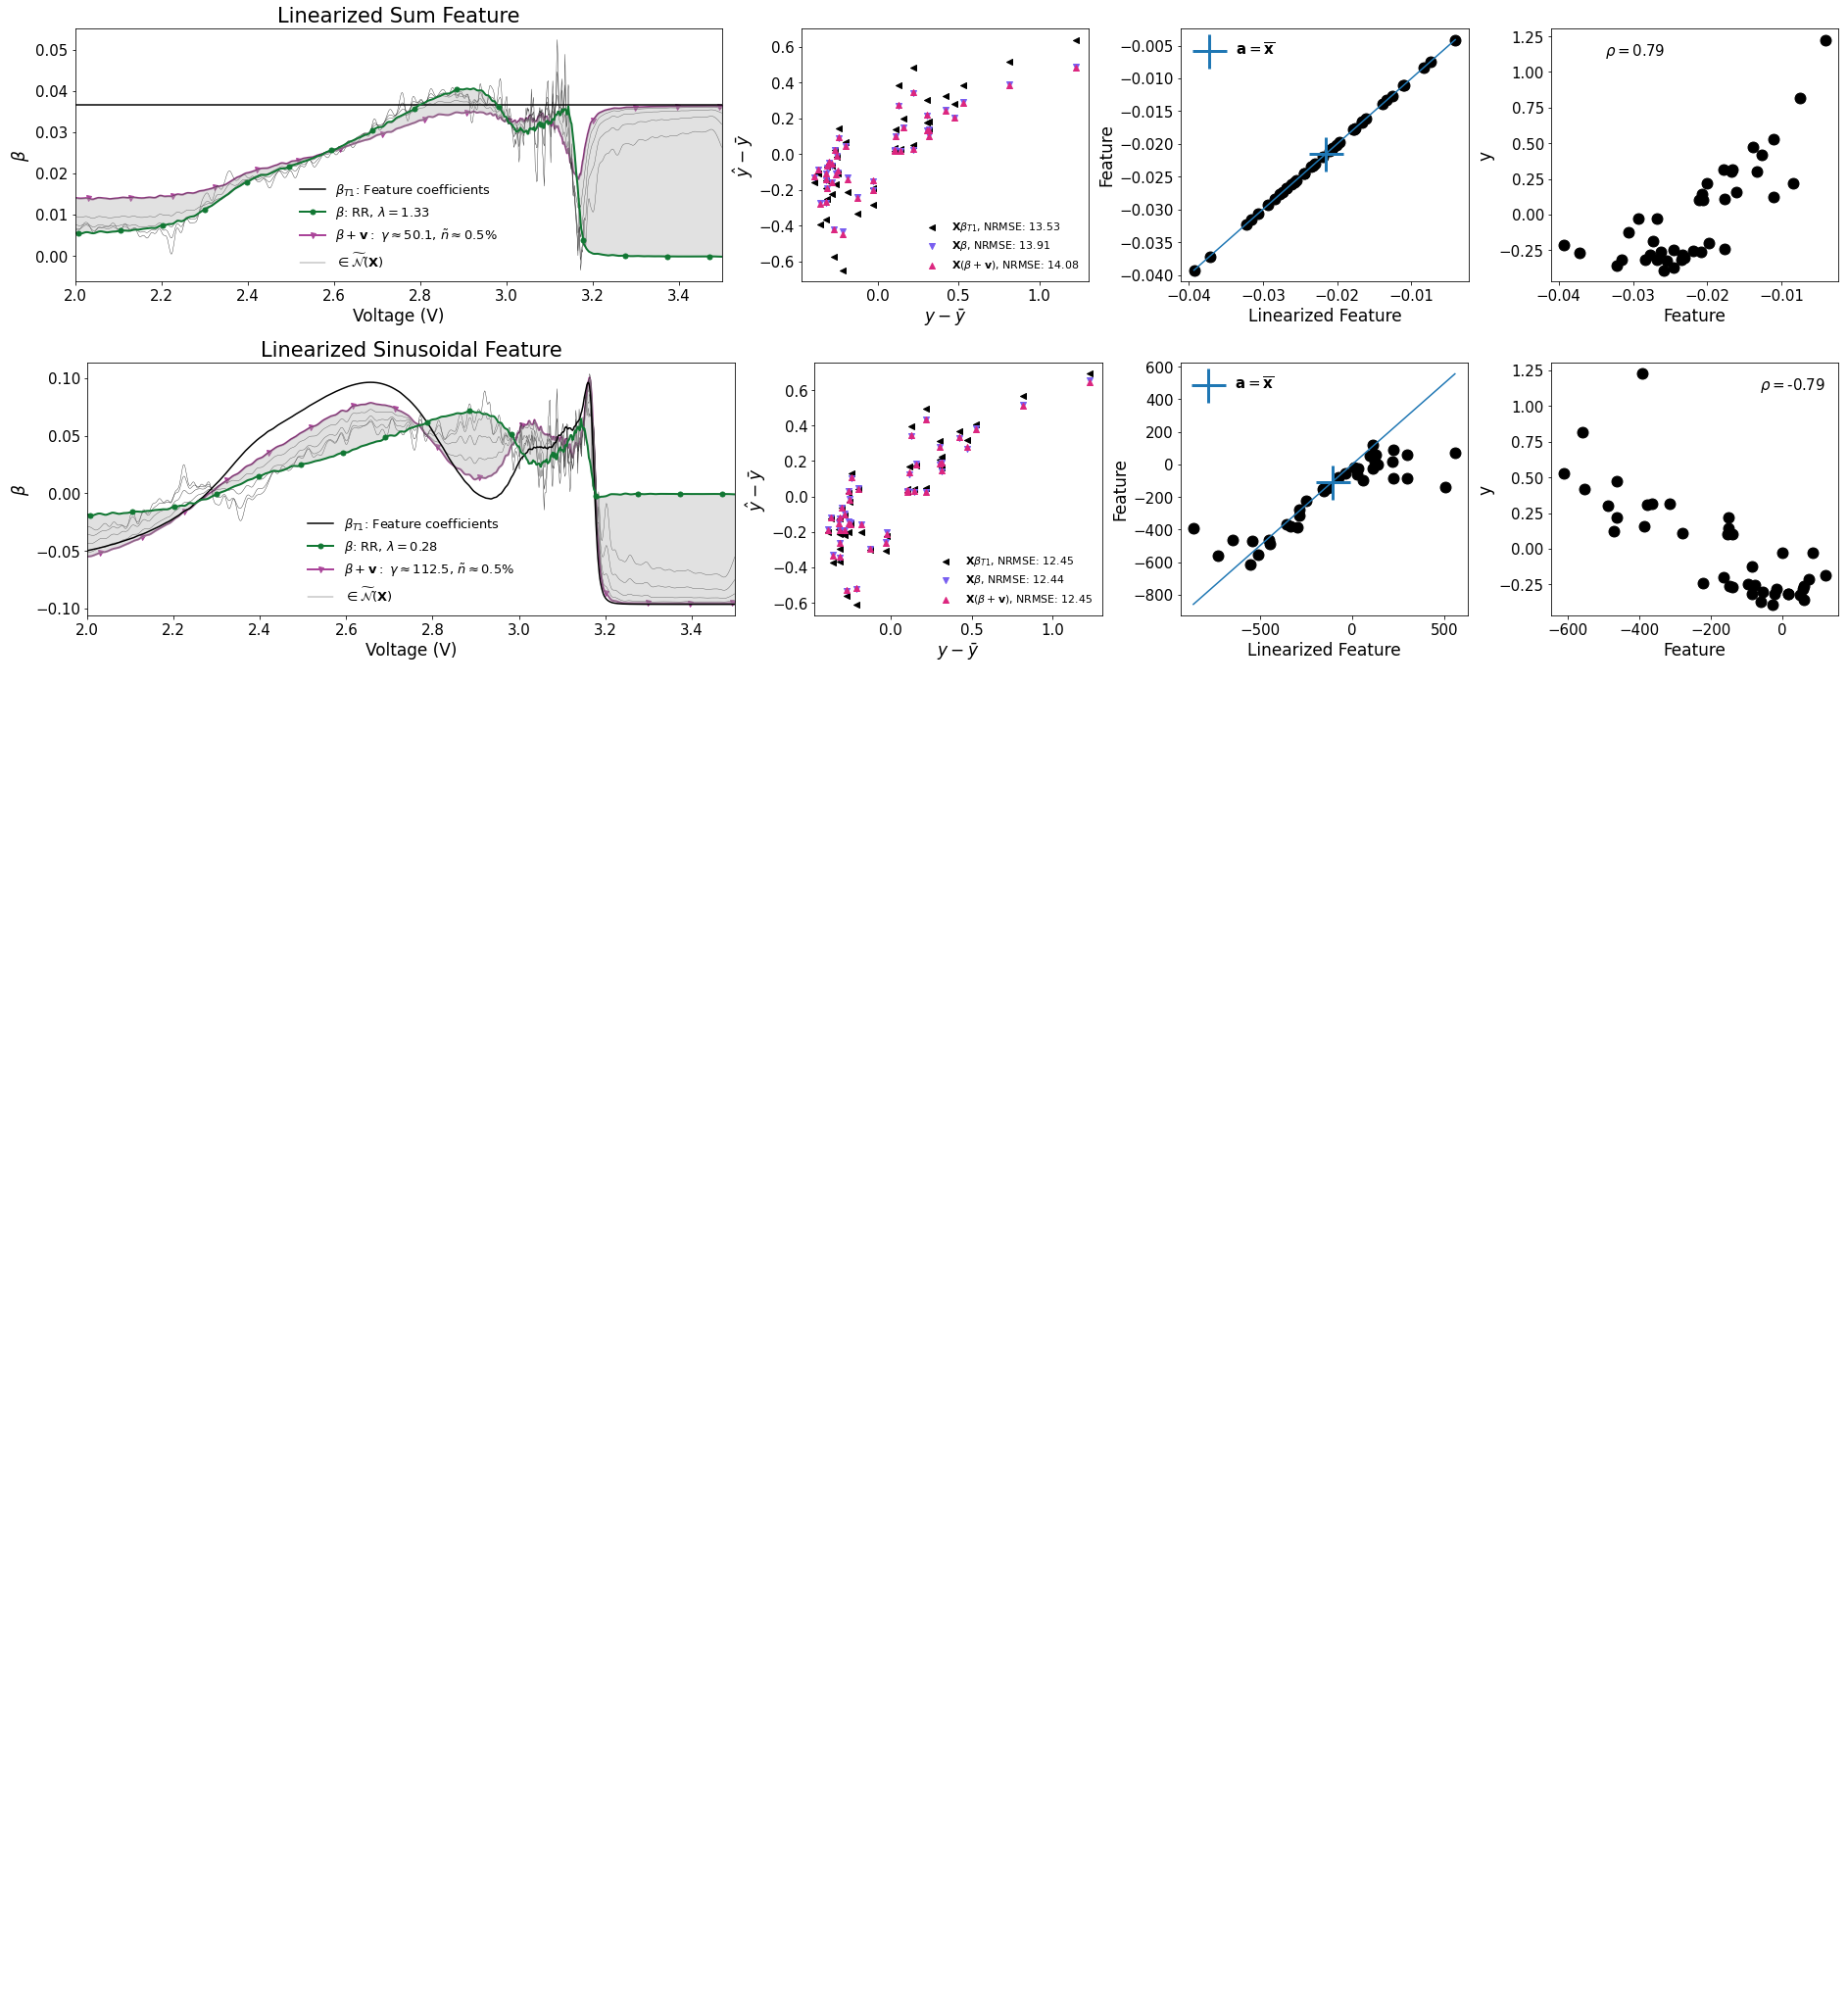

In [23]:
# Log Cycle Life
fig_props = {'save':save_plots, 'ax0_xlabel':'Voltage (V)', 'save_path':save_path + 'LCL_RR_',
            'multiple_fig':False}

fl_lfp_lcl = Featlin(data_obj=lfp_lcl, feat_funcs=feat_fun_dict)

# Run the tests
fl_lfp_lcl = fl_lfp_lcl.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props, con_thres=0.5, verbose=False)
plt.show()